# Predicting Student Admissions with Neural Networks in Keras
In this notebook, we predict student admissions to graduate school at UCLA based on three pieces of data:
- GRE Scores (Test)
- GPA Scores (Grades)
- Class rank (1-4)

The dataset originally came from here: http://www.ats.ucla.edu/

## Loading the data
To load the data and format it nicely, we will use two very useful packages called Pandas and Numpy. You can read on the documentation here:
- https://pandas.pydata.org/pandas-docs/stable/
- https://docs.scipy.org/

In [1]:
# Importing pandas and numpy
import pandas as pd
import numpy as np

# Reading the csv file into a pandas DataFrame
data = pd.read_csv('student_data.csv')

# Printing out the first 10 rows of our data
data[:10]

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4
5,1,760,3.00,2
6,1,560,2.98,1
7,0,400,3.08,2
8,1,540,3.39,3
9,0,700,3.92,2


## Plotting the data

First let's make a plot of our data to see how it looks. In order to have a 2D plot, let's ingore the rank.

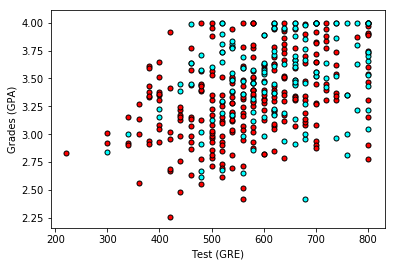

In [3]:
# Importing matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Function to help us plot
def plot_points(data):
    X = np.array(data[["gre","gpa"]])
    y = np.array(data["admit"])
    admitted = X[np.argwhere(y==1)]
    rejected = X[np.argwhere(y==0)]
    plt.scatter([s[0][0] for s in rejected], [s[0][1] for s in rejected], s = 25, color = 'red', edgecolor = 'k')
    plt.scatter([s[0][0] for s in admitted], [s[0][1] for s in admitted], s = 25, color = 'cyan', edgecolor = 'k')
    plt.xlabel('Test (GRE)')
    plt.ylabel('Grades (GPA)')
    
# Plotting the points
plot_points(data)
plt.show()

Roughly, it looks like the students with high scores in the grades and test passed, while the ones with low scores didn't, but the data is not as nicely separable as we hoped it would. Maybe it would help to take the rank into account? Let's make 4 plots, each one for each rank.

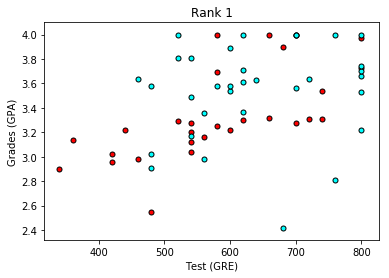

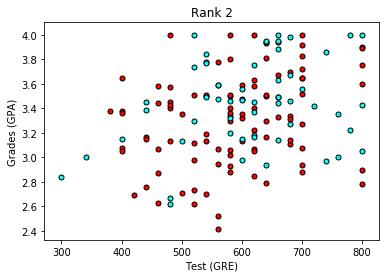

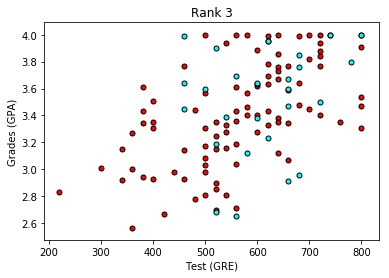

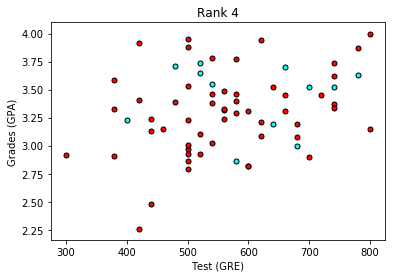

In [4]:
# Separating the ranks
data_rank1 = data[data["rank"]==1]
data_rank2 = data[data["rank"]==2]
data_rank3 = data[data["rank"]==3]
data_rank4 = data[data["rank"]==4]

# Plotting the graphs
plot_points(data_rank1)
plt.title("Rank 1")
plt.show()
plot_points(data_rank2)
plt.title("Rank 2")
plt.show()
plot_points(data_rank3)
plt.title("Rank 3")
plt.show()
plot_points(data_rank4)
plt.title("Rank 4")
plt.show()

This looks more promising, as it seems that the lower the rank, the higher the acceptance rate. Let's use the rank as one of our inputs. In order to do this, we should one-hot encode it.

## One-hot encoding the rank
For this, we'll use the `get_dummies` function in pandas.

In [5]:
# Make dummy variables for rank
one_hot_data = pd.concat([data, pd.get_dummies(data['rank'], prefix='rank')], axis=1)

# Drop the previous rank column
one_hot_data = one_hot_data.drop('rank', axis=1)

# Print the first 10 rows of our data
one_hot_data[:10]

,admit,gre,gpa,rank_1,rank_2,rank_3,rank_4
0,0,380,3.61,0,0,1,0
1,1,660,3.67,0,0,1,0
2,1,800,4.00,1,0,0,0
3,1,640,3.19,0,0,0,1
4,0,520,2.93,0,0,0,1
5,1,760,3.00,0,1,0,0
6,1,560,2.98,1,0,0,0
7,0,400,3.08,0,1,0,0
8,1,540,3.39,0,0,1,0
9,0,700,3.92,0,1,0,0


## Scaling the data
The next step is to scale the data. We notice that the range for grades is 1.0-4.0, whereas the range for test scores is roughly 200-800, which is much larger. This means our data is skewed, and that makes it hard for a neural network to handle. Let's fit our two features into a range of 0-1, by dividing the grades by 4.0, and the test score by 800.

In [6]:
# Copying our data
processed_data = one_hot_data[:]

# Scaling the columns
processed_data['gre'] = processed_data['gre']/800
processed_data['gpa'] = processed_data['gpa']/4.0
processed_data[:10]

,admit,gre,gpa,rank_1,rank_2,rank_3,rank_4
0,0,0.475,0.9025,0,0,1,0
1,1,0.825,0.9175,0,0,1,0
2,1,1.000,1.0000,1,0,0,0
3,1,0.800,0.7975,0,0,0,1
4,0,0.650,0.7325,0,0,0,1
5,1,0.950,0.7500,0,1,0,0
6,1,0.700,0.7450,1,0,0,0
7,0,0.500,0.7700,0,1,0,0
8,1,0.675,0.8475,0,0,1,0
9,0,0.875,0.9800,0,1,0,0


## Splitting the data into Training and Testing

In order to test our algorithm, we'll split the data into a Training and a Testing set. The size of the testing set will be 10% of the total data.

In [7]:
sample = np.random.choice(processed_data.index, size=int(len(processed_data)*0.9), replace=False)
train_data, test_data = processed_data.iloc[sample], processed_data.drop(sample)

print("Number of training samples is", len(train_data))
print("Number of testing samples is", len(test_data))
print(train_data[:10])
print(test_data[:10])

Number of training samples is 360
Number of testing samples is 40
     admit    gre     gpa  rank_1  rank_2  rank_3  rank_4
183      1  0.675  0.9600       0       1       0       0
294      0  0.600  0.6375       1       0       0       0
40       0  0.700  0.6050       0       1       0       0
218      0  0.575  0.7450       1       0       0       0
279      1  0.825  0.7850       0       1       0       0
224      0  1.000  0.7250       0       1       0       0
253      1  0.675  0.8875       0       0       0       1
21       1  0.825  0.9075       0       1       0       0
193      0  0.475  0.8975       0       0       0       1
129      0  0.575  0.7875       0       0       0       1
     admit    gre     gpa  rank_1  rank_2  rank_3  rank_4
15       0  0.600  0.8600       0       0       1       0
26       1  0.775  0.9025       1       0       0       0
28       1  0.975  0.8050       0       1       0       0
46       1  0.725  0.8650       0       1       0       0
54    

## Splitting the data into features and targets (labels)
Now, as a final step before the training, we'll split the data into features (X) and targets (y).

Also, in Keras, we need to one-hot encode the output. We'll do this with the `to_categorical function`.

In [12]:
import keras

# Separate data and one-hot encode the output
# Note: We're also turning the data into numpy arrays, in order to train the model in Keras
features = np.array(train_data.drop('admit', axis=1))
targets = np.array(keras.utils.to_categorical(train_data['admit'], 2))
features_test = np.array(test_data.drop('admit', axis=1))
targets_test = np.array(keras.utils.to_categorical(test_data['admit'], 2))

print(features[:10])
print(targets[:10])

[[0.675  0.96   0.     1.     0.     0.    ]
 [0.6    0.6375 1.     0.     0.     0.    ]
 [0.7    0.605  0.     1.     0.     0.    ]
 [0.575  0.745  1.     0.     0.     0.    ]
 [0.825  0.785  0.     1.     0.     0.    ]
 [1.     0.725  0.     1.     0.     0.    ]
 [0.675  0.8875 0.     0.     0.     1.    ]
 [0.825  0.9075 0.     1.     0.     0.    ]
 [0.475  0.8975 0.     0.     0.     1.    ]
 [0.575  0.7875 0.     0.     0.     1.    ]]
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


## Defining the model architecture
Here's where we use Keras to build our neural network.

In [30]:
# Imports
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils

# Building the model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(6,)))
model.add(Dropout(.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(.1))
model.add(Dense(2, activation='softmax'))

# Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 128)               896       
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 258       
Total params: 17,666
Trainable params: 17,666
Non-trainable params: 0
_________________________________________________________________


## Training the model

In [31]:
# Training the model
model.fit(features, targets, epochs=10000, batch_size=100, verbose=1)

Epoch 1/10000
360/360 [==============================] - 0s 1ms/step - loss: 0.7008 - acc: 0.4889
Epoch 2/10000
360/360 [==============================] - 0s 25us/step - loss: 0.6483 - acc: 0.6861
Epoch 3/10000
360/360 [==============================] - 0s 32us/step - loss: 0.6231 - acc: 0.6861
Epoch 4/10000
360/360 [==============================] - 0s 28us/step - loss: 0.6128 - acc: 0.6861
Epoch 5/10000
360/360 [==============================] - 0s 27us/step - loss: 0.6104 - acc: 0.6861
Epoch 6/10000
360/360 [==============================] - 0s 39us/step - loss: 0.6025 - acc: 0.6889
Epoch 7/10000
360/360 [==============================] - 0s 33us/step - loss: 0.6026 - acc: 0.6972
Epoch 8/10000
360/360 [==============================] - 0s 26us/step - loss: 0.5923 - acc: 0.6944
Epoch 9/10000
360/360 [==============================] - 0s 50us/step - loss: 0.5968 - acc: 0.7028
Epoch 10/10000
360/360 [==============================] - 0s 28us/step - loss: 0.5981 - acc: 0.7028
Epoch 11/1

360/360 [==============================] - 0s 26us/step - loss: 0.5716 - acc: 0.7083
Epoch 84/10000
360/360 [==============================] - 0s 27us/step - loss: 0.5765 - acc: 0.6972
Epoch 85/10000
360/360 [==============================] - 0s 33us/step - loss: 0.5650 - acc: 0.7194
Epoch 86/10000
360/360 [==============================] - 0s 26us/step - loss: 0.5825 - acc: 0.7111
Epoch 87/10000
360/360 [==============================] - 0s 28us/step - loss: 0.5699 - acc: 0.7111
Epoch 88/10000
360/360 [==============================] - 0s 28us/step - loss: 0.5719 - acc: 0.7028
Epoch 89/10000
360/360 [==============================] - 0s 25us/step - loss: 0.5691 - acc: 0.7056
Epoch 90/10000
360/360 [==============================] - 0s 34us/step - loss: 0.5774 - acc: 0.7083
Epoch 91/10000
360/360 [==============================] - 0s 27us/step - loss: 0.5729 - acc: 0.7056
Epoch 92/10000
360/360 [==============================] - 0s 33us/step - loss: 0.5779 - acc: 0.7000
Epoch 93/10000


360/360 [==============================] - 0s 29us/step - loss: 0.5702 - acc: 0.7139
Epoch 165/10000
360/360 [==============================] - 0s 26us/step - loss: 0.5645 - acc: 0.7250
Epoch 166/10000
360/360 [==============================] - 0s 25us/step - loss: 0.5638 - acc: 0.7167
Epoch 167/10000
360/360 [==============================] - 0s 30us/step - loss: 0.5618 - acc: 0.7167
Epoch 168/10000
360/360 [==============================] - 0s 31us/step - loss: 0.5758 - acc: 0.7000
Epoch 169/10000
360/360 [==============================] - 0s 25us/step - loss: 0.5691 - acc: 0.7028
Epoch 170/10000
360/360 [==============================] - 0s 24us/step - loss: 0.5677 - acc: 0.7139
Epoch 171/10000
360/360 [==============================] - 0s 29us/step - loss: 0.5688 - acc: 0.7083
Epoch 172/10000
360/360 [==============================] - 0s 27us/step - loss: 0.5607 - acc: 0.7056
Epoch 173/10000
360/360 [==============================] - 0s 31us/step - loss: 0.5666 - acc: 0.7111
Epoch 

360/360 [==============================] - 0s 32us/step - loss: 0.5605 - acc: 0.7111
Epoch 246/10000
360/360 [==============================] - 0s 25us/step - loss: 0.5542 - acc: 0.7278
Epoch 247/10000
360/360 [==============================] - 0s 29us/step - loss: 0.5572 - acc: 0.7139
Epoch 248/10000
360/360 [==============================] - 0s 30us/step - loss: 0.5641 - acc: 0.7056
Epoch 249/10000
360/360 [==============================] - 0s 28us/step - loss: 0.5656 - acc: 0.7028
Epoch 250/10000
360/360 [==============================] - 0s 30us/step - loss: 0.5634 - acc: 0.7083
Epoch 251/10000
360/360 [==============================] - 0s 27us/step - loss: 0.5653 - acc: 0.7278
Epoch 252/10000
360/360 [==============================] - 0s 28us/step - loss: 0.5611 - acc: 0.7167
Epoch 253/10000
360/360 [==============================] - 0s 28us/step - loss: 0.5650 - acc: 0.7250
Epoch 254/10000
360/360 [==============================] - 0s 33us/step - loss: 0.5574 - acc: 0.7028
Epoch 

360/360 [==============================] - 0s 32us/step - loss: 0.5597 - acc: 0.7194
Epoch 327/10000
360/360 [==============================] - 0s 34us/step - loss: 0.5613 - acc: 0.7056
Epoch 328/10000
360/360 [==============================] - 0s 35us/step - loss: 0.5543 - acc: 0.7194
Epoch 329/10000
360/360 [==============================] - 0s 34us/step - loss: 0.5574 - acc: 0.7139
Epoch 330/10000
360/360 [==============================] - 0s 33us/step - loss: 0.5567 - acc: 0.7167
Epoch 331/10000
360/360 [==============================] - 0s 29us/step - loss: 0.5562 - acc: 0.7194
Epoch 332/10000
360/360 [==============================] - 0s 38us/step - loss: 0.5583 - acc: 0.7083
Epoch 333/10000
360/360 [==============================] - 0s 38us/step - loss: 0.5557 - acc: 0.7083
Epoch 334/10000
360/360 [==============================] - 0s 37us/step - loss: 0.5532 - acc: 0.7111
Epoch 335/10000
360/360 [==============================] - 0s 37us/step - loss: 0.5531 - acc: 0.7139
Epoch 

360/360 [==============================] - 0s 30us/step - loss: 0.5548 - acc: 0.7111
Epoch 408/10000
360/360 [==============================] - 0s 26us/step - loss: 0.5578 - acc: 0.7250
Epoch 409/10000
360/360 [==============================] - 0s 28us/step - loss: 0.5502 - acc: 0.7333
Epoch 410/10000
360/360 [==============================] - 0s 30us/step - loss: 0.5523 - acc: 0.7194
Epoch 411/10000
360/360 [==============================] - 0s 25us/step - loss: 0.5481 - acc: 0.7028
Epoch 412/10000
360/360 [==============================] - 0s 30us/step - loss: 0.5468 - acc: 0.7139
Epoch 413/10000
360/360 [==============================] - 0s 31us/step - loss: 0.5572 - acc: 0.7056
Epoch 414/10000
360/360 [==============================] - 0s 30us/step - loss: 0.5524 - acc: 0.7167
Epoch 415/10000
360/360 [==============================] - 0s 37us/step - loss: 0.5589 - acc: 0.7333
Epoch 416/10000
360/360 [==============================] - 0s 34us/step - loss: 0.5462 - acc: 0.7278
Epoch 

360/360 [==============================] - 0s 31us/step - loss: 0.5419 - acc: 0.7306
Epoch 489/10000
360/360 [==============================] - 0s 29us/step - loss: 0.5498 - acc: 0.7278
Epoch 490/10000
360/360 [==============================] - 0s 27us/step - loss: 0.5498 - acc: 0.7083
Epoch 491/10000
360/360 [==============================] - 0s 32us/step - loss: 0.5453 - acc: 0.7250
Epoch 492/10000
360/360 [==============================] - 0s 33us/step - loss: 0.5470 - acc: 0.7194
Epoch 493/10000
360/360 [==============================] - 0s 28us/step - loss: 0.5474 - acc: 0.7167
Epoch 494/10000
360/360 [==============================] - 0s 31us/step - loss: 0.5394 - acc: 0.7250
Epoch 495/10000
360/360 [==============================] - 0s 33us/step - loss: 0.5447 - acc: 0.7250
Epoch 496/10000
360/360 [==============================] - 0s 29us/step - loss: 0.5420 - acc: 0.7250
Epoch 497/10000
360/360 [==============================] - 0s 29us/step - loss: 0.5488 - acc: 0.7278
Epoch 

360/360 [==============================] - 0s 28us/step - loss: 0.5385 - acc: 0.7250
Epoch 570/10000
360/360 [==============================] - 0s 26us/step - loss: 0.5439 - acc: 0.7194
Epoch 571/10000
360/360 [==============================] - 0s 25us/step - loss: 0.5402 - acc: 0.7306
Epoch 572/10000
360/360 [==============================] - 0s 30us/step - loss: 0.5424 - acc: 0.7333
Epoch 573/10000
360/360 [==============================] - 0s 24us/step - loss: 0.5456 - acc: 0.7250
Epoch 574/10000
360/360 [==============================] - 0s 30us/step - loss: 0.5466 - acc: 0.7250
Epoch 575/10000
360/360 [==============================] - 0s 27us/step - loss: 0.5342 - acc: 0.7250
Epoch 576/10000
360/360 [==============================] - 0s 28us/step - loss: 0.5288 - acc: 0.7389
Epoch 577/10000
360/360 [==============================] - 0s 36us/step - loss: 0.5364 - acc: 0.7278
Epoch 578/10000
360/360 [==============================] - 0s 30us/step - loss: 0.5366 - acc: 0.7222
Epoch 

360/360 [==============================] - 0s 35us/step - loss: 0.5295 - acc: 0.7333
Epoch 651/10000
360/360 [==============================] - 0s 28us/step - loss: 0.5370 - acc: 0.7278
Epoch 652/10000
360/360 [==============================] - 0s 29us/step - loss: 0.5334 - acc: 0.7278
Epoch 653/10000
360/360 [==============================] - 0s 32us/step - loss: 0.5256 - acc: 0.7250
Epoch 654/10000
360/360 [==============================] - 0s 32us/step - loss: 0.5359 - acc: 0.7389
Epoch 655/10000
360/360 [==============================] - 0s 25us/step - loss: 0.5316 - acc: 0.7361
Epoch 656/10000
360/360 [==============================] - 0s 28us/step - loss: 0.5339 - acc: 0.7389
Epoch 657/10000
360/360 [==============================] - 0s 30us/step - loss: 0.5391 - acc: 0.7194
Epoch 658/10000
360/360 [==============================] - 0s 26us/step - loss: 0.5347 - acc: 0.7333
Epoch 659/10000
360/360 [==============================] - 0s 31us/step - loss: 0.5285 - acc: 0.7444
Epoch 

360/360 [==============================] - 0s 32us/step - loss: 0.5207 - acc: 0.7333
Epoch 732/10000
360/360 [==============================] - 0s 29us/step - loss: 0.5265 - acc: 0.7389
Epoch 733/10000
360/360 [==============================] - 0s 26us/step - loss: 0.5207 - acc: 0.7500
Epoch 734/10000
360/360 [==============================] - 0s 29us/step - loss: 0.5269 - acc: 0.7472
Epoch 735/10000
360/360 [==============================] - 0s 33us/step - loss: 0.5253 - acc: 0.7389
Epoch 736/10000
360/360 [==============================] - 0s 26us/step - loss: 0.5264 - acc: 0.7389
Epoch 737/10000
360/360 [==============================] - 0s 30us/step - loss: 0.5291 - acc: 0.7361
Epoch 738/10000
360/360 [==============================] - 0s 35us/step - loss: 0.5198 - acc: 0.7444
Epoch 739/10000
360/360 [==============================] - 0s 29us/step - loss: 0.5250 - acc: 0.7278
Epoch 740/10000
360/360 [==============================] - 0s 27us/step - loss: 0.5228 - acc: 0.7500
Epoch 

360/360 [==============================] - 0s 29us/step - loss: 0.5108 - acc: 0.7472
Epoch 813/10000
360/360 [==============================] - 0s 27us/step - loss: 0.5184 - acc: 0.7389
Epoch 814/10000
360/360 [==============================] - 0s 31us/step - loss: 0.5244 - acc: 0.7389
Epoch 815/10000
360/360 [==============================] - 0s 32us/step - loss: 0.5267 - acc: 0.7472
Epoch 816/10000
360/360 [==============================] - 0s 26us/step - loss: 0.5191 - acc: 0.7472
Epoch 817/10000
360/360 [==============================] - 0s 33us/step - loss: 0.5167 - acc: 0.7417
Epoch 818/10000
360/360 [==============================] - 0s 32us/step - loss: 0.5131 - acc: 0.7444
Epoch 819/10000
360/360 [==============================] - 0s 27us/step - loss: 0.5177 - acc: 0.7250
Epoch 820/10000
360/360 [==============================] - 0s 32us/step - loss: 0.5117 - acc: 0.7500
Epoch 821/10000
360/360 [==============================] - 0s 32us/step - loss: 0.5167 - acc: 0.7444
Epoch 

360/360 [==============================] - 0s 32us/step - loss: 0.5054 - acc: 0.7444
Epoch 894/10000
360/360 [==============================] - 0s 25us/step - loss: 0.5188 - acc: 0.7556
Epoch 895/10000
360/360 [==============================] - 0s 30us/step - loss: 0.5129 - acc: 0.7389
Epoch 896/10000
360/360 [==============================] - 0s 31us/step - loss: 0.5063 - acc: 0.7472
Epoch 897/10000
360/360 [==============================] - 0s 27us/step - loss: 0.5129 - acc: 0.7444
Epoch 898/10000
360/360 [==============================] - 0s 30us/step - loss: 0.5016 - acc: 0.7556
Epoch 899/10000
360/360 [==============================] - 0s 32us/step - loss: 0.4985 - acc: 0.7556
Epoch 900/10000
360/360 [==============================] - 0s 26us/step - loss: 0.4970 - acc: 0.7556
Epoch 901/10000
360/360 [==============================] - 0s 33us/step - loss: 0.5076 - acc: 0.7500
Epoch 902/10000
360/360 [==============================] - 0s 32us/step - loss: 0.5050 - acc: 0.7639
Epoch 

360/360 [==============================] - 0s 28us/step - loss: 0.4977 - acc: 0.7556
Epoch 975/10000
360/360 [==============================] - 0s 27us/step - loss: 0.4973 - acc: 0.7611
Epoch 976/10000
360/360 [==============================] - 0s 32us/step - loss: 0.5137 - acc: 0.7417
Epoch 977/10000
360/360 [==============================] - 0s 28us/step - loss: 0.4966 - acc: 0.7389
Epoch 978/10000
360/360 [==============================] - 0s 26us/step - loss: 0.4983 - acc: 0.7667
Epoch 979/10000
360/360 [==============================] - 0s 33us/step - loss: 0.4975 - acc: 0.7611
Epoch 980/10000
360/360 [==============================] - 0s 27us/step - loss: 0.5005 - acc: 0.7417
Epoch 981/10000
360/360 [==============================] - 0s 26us/step - loss: 0.5095 - acc: 0.7472
Epoch 982/10000
360/360 [==============================] - 0s 30us/step - loss: 0.5034 - acc: 0.7500
Epoch 983/10000
360/360 [==============================] - 0s 27us/step - loss: 0.5073 - acc: 0.7500
Epoch 

360/360 [==============================] - 0s 25us/step - loss: 0.4991 - acc: 0.7417
Epoch 1055/10000
360/360 [==============================] - 0s 30us/step - loss: 0.4953 - acc: 0.7611
Epoch 1056/10000
360/360 [==============================] - 0s 30us/step - loss: 0.5072 - acc: 0.7500
Epoch 1057/10000
360/360 [==============================] - 0s 24us/step - loss: 0.4957 - acc: 0.7583
Epoch 1058/10000
360/360 [==============================] - 0s 34us/step - loss: 0.4882 - acc: 0.7750
Epoch 1059/10000
360/360 [==============================] - 0s 33us/step - loss: 0.4893 - acc: 0.7583
Epoch 1060/10000
360/360 [==============================] - 0s 29us/step - loss: 0.4938 - acc: 0.7583
Epoch 1061/10000
360/360 [==============================] - 0s 27us/step - loss: 0.4846 - acc: 0.7556
Epoch 1062/10000
360/360 [==============================] - 0s 31us/step - loss: 0.4974 - acc: 0.7500
Epoch 1063/10000
360/360 [==============================] - 0s 31us/step - loss: 0.4939 - acc: 0.74

360/360 [==============================] - 0s 32us/step - loss: 0.4857 - acc: 0.7667
Epoch 1135/10000
360/360 [==============================] - 0s 28us/step - loss: 0.4904 - acc: 0.7583
Epoch 1136/10000
360/360 [==============================] - 0s 25us/step - loss: 0.4824 - acc: 0.7583
Epoch 1137/10000
360/360 [==============================] - 0s 32us/step - loss: 0.4890 - acc: 0.7611
Epoch 1138/10000
360/360 [==============================] - 0s 27us/step - loss: 0.4878 - acc: 0.7639
Epoch 1139/10000
360/360 [==============================] - 0s 27us/step - loss: 0.4942 - acc: 0.7556
Epoch 1140/10000
360/360 [==============================] - 0s 30us/step - loss: 0.4913 - acc: 0.7528
Epoch 1141/10000
360/360 [==============================] - 0s 31us/step - loss: 0.4843 - acc: 0.7472
Epoch 1142/10000
360/360 [==============================] - 0s 27us/step - loss: 0.4786 - acc: 0.7611
Epoch 1143/10000
360/360 [==============================] - 0s 32us/step - loss: 0.4959 - acc: 0.75

360/360 [==============================] - 0s 26us/step - loss: 0.4836 - acc: 0.7611
Epoch 1215/10000
360/360 [==============================] - 0s 29us/step - loss: 0.4860 - acc: 0.7667
Epoch 1216/10000
360/360 [==============================] - 0s 33us/step - loss: 0.4832 - acc: 0.7667
Epoch 1217/10000
360/360 [==============================] - 0s 31us/step - loss: 0.4968 - acc: 0.7417
Epoch 1218/10000
360/360 [==============================] - 0s 27us/step - loss: 0.4790 - acc: 0.7667
Epoch 1219/10000
360/360 [==============================] - 0s 32us/step - loss: 0.4850 - acc: 0.7639
Epoch 1220/10000
360/360 [==============================] - 0s 32us/step - loss: 0.4794 - acc: 0.7556
Epoch 1221/10000
360/360 [==============================] - 0s 30us/step - loss: 0.4671 - acc: 0.7583
Epoch 1222/10000
360/360 [==============================] - 0s 28us/step - loss: 0.4866 - acc: 0.7611
Epoch 1223/10000
360/360 [==============================] - 0s 34us/step - loss: 0.4765 - acc: 0.76

360/360 [==============================] - 0s 28us/step - loss: 0.4800 - acc: 0.7583
Epoch 1295/10000
360/360 [==============================] - 0s 30us/step - loss: 0.4675 - acc: 0.7528
Epoch 1296/10000
360/360 [==============================] - 0s 31us/step - loss: 0.4862 - acc: 0.7583
Epoch 1297/10000
360/360 [==============================] - 0s 28us/step - loss: 0.4784 - acc: 0.7639
Epoch 1298/10000
360/360 [==============================] - 0s 29us/step - loss: 0.4775 - acc: 0.7611
Epoch 1299/10000
360/360 [==============================] - 0s 32us/step - loss: 0.4718 - acc: 0.7639
Epoch 1300/10000
360/360 [==============================] - 0s 28us/step - loss: 0.4645 - acc: 0.7778
Epoch 1301/10000
360/360 [==============================] - 0s 30us/step - loss: 0.4647 - acc: 0.7750
Epoch 1302/10000
360/360 [==============================] - 0s 34us/step - loss: 0.4633 - acc: 0.7778
Epoch 1303/10000
360/360 [==============================] - 0s 31us/step - loss: 0.4689 - acc: 0.76

360/360 [==============================] - 0s 32us/step - loss: 0.4816 - acc: 0.7500
Epoch 1375/10000
360/360 [==============================] - 0s 28us/step - loss: 0.4763 - acc: 0.7722
Epoch 1376/10000
360/360 [==============================] - 0s 27us/step - loss: 0.4715 - acc: 0.7639
Epoch 1377/10000
360/360 [==============================] - 0s 36us/step - loss: 0.4634 - acc: 0.7583
Epoch 1378/10000
360/360 [==============================] - 0s 30us/step - loss: 0.4772 - acc: 0.7528
Epoch 1379/10000
360/360 [==============================] - 0s 27us/step - loss: 0.4649 - acc: 0.7778
Epoch 1380/10000
360/360 [==============================] - 0s 32us/step - loss: 0.4617 - acc: 0.7778
Epoch 1381/10000
360/360 [==============================] - 0s 29us/step - loss: 0.4644 - acc: 0.7694
Epoch 1382/10000
360/360 [==============================] - 0s 29us/step - loss: 0.4699 - acc: 0.7833
Epoch 1383/10000
360/360 [==============================] - 0s 28us/step - loss: 0.4715 - acc: 0.76

360/360 [==============================] - 0s 30us/step - loss: 0.4637 - acc: 0.7694
Epoch 1455/10000
360/360 [==============================] - 0s 32us/step - loss: 0.4523 - acc: 0.7806
Epoch 1456/10000
360/360 [==============================] - 0s 28us/step - loss: 0.4568 - acc: 0.7806
Epoch 1457/10000
360/360 [==============================] - 0s 30us/step - loss: 0.4639 - acc: 0.7639
Epoch 1458/10000
360/360 [==============================] - 0s 28us/step - loss: 0.4769 - acc: 0.7611
Epoch 1459/10000
360/360 [==============================] - 0s 24us/step - loss: 0.4711 - acc: 0.7556
Epoch 1460/10000
360/360 [==============================] - 0s 28us/step - loss: 0.4586 - acc: 0.7667
Epoch 1461/10000
360/360 [==============================] - 0s 30us/step - loss: 0.4649 - acc: 0.7750
Epoch 1462/10000
360/360 [==============================] - 0s 28us/step - loss: 0.4774 - acc: 0.7694
Epoch 1463/10000
360/360 [==============================] - 0s 35us/step - loss: 0.4723 - acc: 0.76

360/360 [==============================] - 0s 30us/step - loss: 0.4606 - acc: 0.7667
Epoch 1535/10000
360/360 [==============================] - 0s 28us/step - loss: 0.4602 - acc: 0.7806
Epoch 1536/10000
360/360 [==============================] - 0s 34us/step - loss: 0.4744 - acc: 0.7778
Epoch 1537/10000
360/360 [==============================] - 0s 33us/step - loss: 0.4638 - acc: 0.7722
Epoch 1538/10000
360/360 [==============================] - 0s 25us/step - loss: 0.4679 - acc: 0.7583
Epoch 1539/10000
360/360 [==============================] - 0s 29us/step - loss: 0.4616 - acc: 0.7778
Epoch 1540/10000
360/360 [==============================] - 0s 35us/step - loss: 0.4665 - acc: 0.7667
Epoch 1541/10000
360/360 [==============================] - 0s 34us/step - loss: 0.4694 - acc: 0.7861
Epoch 1542/10000
360/360 [==============================] - 0s 30us/step - loss: 0.4804 - acc: 0.7639
Epoch 1543/10000
360/360 [==============================] - 0s 33us/step - loss: 0.4635 - acc: 0.77

360/360 [==============================] - 0s 30us/step - loss: 0.4549 - acc: 0.7778
Epoch 1615/10000
360/360 [==============================] - 0s 25us/step - loss: 0.4634 - acc: 0.7722
Epoch 1616/10000
360/360 [==============================] - 0s 33us/step - loss: 0.4408 - acc: 0.7833
Epoch 1617/10000
360/360 [==============================] - 0s 33us/step - loss: 0.4659 - acc: 0.7722
Epoch 1618/10000
360/360 [==============================] - 0s 25us/step - loss: 0.4550 - acc: 0.7806
Epoch 1619/10000
360/360 [==============================] - 0s 32us/step - loss: 0.4592 - acc: 0.7833
Epoch 1620/10000
360/360 [==============================] - 0s 33us/step - loss: 0.4593 - acc: 0.7611
Epoch 1621/10000
360/360 [==============================] - 0s 33us/step - loss: 0.4607 - acc: 0.7778
Epoch 1622/10000
360/360 [==============================] - 0s 31us/step - loss: 0.4739 - acc: 0.7472
Epoch 1623/10000
360/360 [==============================] - 0s 33us/step - loss: 0.4715 - acc: 0.75

360/360 [==============================] - 0s 27us/step - loss: 0.4443 - acc: 0.7889
Epoch 1695/10000
360/360 [==============================] - 0s 31us/step - loss: 0.4594 - acc: 0.7778
Epoch 1696/10000
360/360 [==============================] - 0s 30us/step - loss: 0.4565 - acc: 0.7778
Epoch 1697/10000
360/360 [==============================] - 0s 26us/step - loss: 0.4571 - acc: 0.7972
Epoch 1698/10000
360/360 [==============================] - 0s 33us/step - loss: 0.4465 - acc: 0.7861
Epoch 1699/10000
360/360 [==============================] - 0s 34us/step - loss: 0.4614 - acc: 0.7583
Epoch 1700/10000
360/360 [==============================] - 0s 25us/step - loss: 0.4693 - acc: 0.7667
Epoch 1701/10000
360/360 [==============================] - 0s 29us/step - loss: 0.4685 - acc: 0.7722
Epoch 1702/10000
360/360 [==============================] - 0s 34us/step - loss: 0.4511 - acc: 0.7833
Epoch 1703/10000
360/360 [==============================] - 0s 32us/step - loss: 0.4644 - acc: 0.77

360/360 [==============================] - 0s 35us/step - loss: 0.4387 - acc: 0.7639
Epoch 1775/10000
360/360 [==============================] - 0s 28us/step - loss: 0.4494 - acc: 0.7806
Epoch 1776/10000
360/360 [==============================] - 0s 36us/step - loss: 0.4476 - acc: 0.7806
Epoch 1777/10000
360/360 [==============================] - 0s 32us/step - loss: 0.4632 - acc: 0.7694
Epoch 1778/10000
360/360 [==============================] - 0s 25us/step - loss: 0.4567 - acc: 0.7889
Epoch 1779/10000
360/360 [==============================] - 0s 34us/step - loss: 0.4701 - acc: 0.7694
Epoch 1780/10000
360/360 [==============================] - 0s 32us/step - loss: 0.4484 - acc: 0.7806
Epoch 1781/10000
360/360 [==============================] - 0s 34us/step - loss: 0.4436 - acc: 0.7611
Epoch 1782/10000
360/360 [==============================] - 0s 24us/step - loss: 0.4409 - acc: 0.7944
Epoch 1783/10000
360/360 [==============================] - 0s 30us/step - loss: 0.4680 - acc: 0.76

360/360 [==============================] - 0s 29us/step - loss: 0.4643 - acc: 0.7639
Epoch 1855/10000
360/360 [==============================] - 0s 33us/step - loss: 0.4449 - acc: 0.7806
Epoch 1856/10000
360/360 [==============================] - 0s 31us/step - loss: 0.4509 - acc: 0.7694
Epoch 1857/10000
360/360 [==============================] - 0s 25us/step - loss: 0.4476 - acc: 0.7750
Epoch 1858/10000
360/360 [==============================] - 0s 31us/step - loss: 0.4438 - acc: 0.7806
Epoch 1859/10000
360/360 [==============================] - 0s 29us/step - loss: 0.4491 - acc: 0.7611
Epoch 1860/10000
360/360 [==============================] - 0s 26us/step - loss: 0.4542 - acc: 0.7722
Epoch 1861/10000
360/360 [==============================] - 0s 28us/step - loss: 0.4593 - acc: 0.7778
Epoch 1862/10000
360/360 [==============================] - 0s 32us/step - loss: 0.4628 - acc: 0.7750
Epoch 1863/10000
360/360 [==============================] - 0s 27us/step - loss: 0.4586 - acc: 0.77

360/360 [==============================] - 0s 29us/step - loss: 0.4425 - acc: 0.8000
Epoch 1935/10000
360/360 [==============================] - 0s 31us/step - loss: 0.4518 - acc: 0.7778
Epoch 1936/10000
360/360 [==============================] - 0s 30us/step - loss: 0.4491 - acc: 0.7861
Epoch 1937/10000
360/360 [==============================] - 0s 27us/step - loss: 0.4403 - acc: 0.7972
Epoch 1938/10000
360/360 [==============================] - 0s 33us/step - loss: 0.4626 - acc: 0.7750
Epoch 1939/10000
360/360 [==============================] - 0s 31us/step - loss: 0.4518 - acc: 0.7778
Epoch 1940/10000
360/360 [==============================] - 0s 34us/step - loss: 0.4523 - acc: 0.7806
Epoch 1941/10000
360/360 [==============================] - 0s 29us/step - loss: 0.4597 - acc: 0.7667
Epoch 1942/10000
360/360 [==============================] - 0s 37us/step - loss: 0.4527 - acc: 0.7833
Epoch 1943/10000
360/360 [==============================] - 0s 36us/step - loss: 0.4556 - acc: 0.78

360/360 [==============================] - 0s 30us/step - loss: 0.4621 - acc: 0.7694
Epoch 2015/10000
360/360 [==============================] - 0s 26us/step - loss: 0.4428 - acc: 0.7833
Epoch 2016/10000
360/360 [==============================] - 0s 29us/step - loss: 0.4363 - acc: 0.7806
Epoch 2017/10000
360/360 [==============================] - 0s 25us/step - loss: 0.4530 - acc: 0.7778
Epoch 2018/10000
360/360 [==============================] - 0s 26us/step - loss: 0.4464 - acc: 0.7806
Epoch 2019/10000
360/360 [==============================] - 0s 27us/step - loss: 0.4513 - acc: 0.7833
Epoch 2020/10000
360/360 [==============================] - 0s 26us/step - loss: 0.4413 - acc: 0.7722
Epoch 2021/10000
360/360 [==============================] - 0s 30us/step - loss: 0.4450 - acc: 0.7889
Epoch 2022/10000
360/360 [==============================] - 0s 30us/step - loss: 0.4612 - acc: 0.7722
Epoch 2023/10000
360/360 [==============================] - 0s 32us/step - loss: 0.4444 - acc: 0.78

360/360 [==============================] - 0s 28us/step - loss: 0.4280 - acc: 0.7861
Epoch 2095/10000
360/360 [==============================] - 0s 23us/step - loss: 0.4333 - acc: 0.7694
Epoch 2096/10000
360/360 [==============================] - 0s 28us/step - loss: 0.4401 - acc: 0.7750
Epoch 2097/10000
360/360 [==============================] - 0s 25us/step - loss: 0.4284 - acc: 0.7806
Epoch 2098/10000
360/360 [==============================] - 0s 29us/step - loss: 0.4443 - acc: 0.7778
Epoch 2099/10000
360/360 [==============================] - 0s 26us/step - loss: 0.4431 - acc: 0.7778
Epoch 2100/10000
360/360 [==============================] - 0s 24us/step - loss: 0.4332 - acc: 0.7889
Epoch 2101/10000
360/360 [==============================] - 0s 25us/step - loss: 0.4444 - acc: 0.7806
Epoch 2102/10000
360/360 [==============================] - 0s 25us/step - loss: 0.4378 - acc: 0.7917
Epoch 2103/10000
360/360 [==============================] - 0s 28us/step - loss: 0.4420 - acc: 0.78

360/360 [==============================] - 0s 29us/step - loss: 0.4619 - acc: 0.7694
Epoch 2175/10000
360/360 [==============================] - 0s 31us/step - loss: 0.4377 - acc: 0.7889
Epoch 2176/10000
360/360 [==============================] - 0s 34us/step - loss: 0.4461 - acc: 0.7750
Epoch 2177/10000
360/360 [==============================] - 0s 29us/step - loss: 0.4324 - acc: 0.7889
Epoch 2178/10000
360/360 [==============================] - 0s 30us/step - loss: 0.4381 - acc: 0.8056
Epoch 2179/10000
360/360 [==============================] - 0s 34us/step - loss: 0.4497 - acc: 0.7806
Epoch 2180/10000
360/360 [==============================] - 0s 33us/step - loss: 0.4410 - acc: 0.7972
Epoch 2181/10000
360/360 [==============================] - 0s 32us/step - loss: 0.4519 - acc: 0.7722
Epoch 2182/10000
360/360 [==============================] - 0s 34us/step - loss: 0.4480 - acc: 0.7750
Epoch 2183/10000
360/360 [==============================] - 0s 34us/step - loss: 0.4426 - acc: 0.77

360/360 [==============================] - 0s 32us/step - loss: 0.4367 - acc: 0.7778
Epoch 2255/10000
360/360 [==============================] - 0s 32us/step - loss: 0.4579 - acc: 0.7722
Epoch 2256/10000
360/360 [==============================] - 0s 34us/step - loss: 0.4447 - acc: 0.7917
Epoch 2257/10000
360/360 [==============================] - 0s 30us/step - loss: 0.4373 - acc: 0.7917
Epoch 2258/10000
360/360 [==============================] - 0s 26us/step - loss: 0.4412 - acc: 0.7833
Epoch 2259/10000
360/360 [==============================] - 0s 28us/step - loss: 0.4206 - acc: 0.7833
Epoch 2260/10000
360/360 [==============================] - 0s 28us/step - loss: 0.4380 - acc: 0.7861
Epoch 2261/10000
360/360 [==============================] - 0s 34us/step - loss: 0.4348 - acc: 0.7944
Epoch 2262/10000
360/360 [==============================] - 0s 32us/step - loss: 0.4276 - acc: 0.7833
Epoch 2263/10000
360/360 [==============================] - 0s 34us/step - loss: 0.4340 - acc: 0.78

360/360 [==============================] - 0s 30us/step - loss: 0.4323 - acc: 0.7944
Epoch 2335/10000
360/360 [==============================] - 0s 28us/step - loss: 0.4235 - acc: 0.7806
Epoch 2336/10000
360/360 [==============================] - 0s 26us/step - loss: 0.4237 - acc: 0.7889
Epoch 2337/10000
360/360 [==============================] - 0s 25us/step - loss: 0.4476 - acc: 0.7806
Epoch 2338/10000
360/360 [==============================] - 0s 27us/step - loss: 0.4282 - acc: 0.7917
Epoch 2339/10000
360/360 [==============================] - 0s 30us/step - loss: 0.4293 - acc: 0.7889
Epoch 2340/10000
360/360 [==============================] - 0s 32us/step - loss: 0.4303 - acc: 0.7944
Epoch 2341/10000
360/360 [==============================] - 0s 28us/step - loss: 0.4258 - acc: 0.7944
Epoch 2342/10000
360/360 [==============================] - 0s 31us/step - loss: 0.4315 - acc: 0.7833
Epoch 2343/10000
360/360 [==============================] - 0s 31us/step - loss: 0.4281 - acc: 0.79

360/360 [==============================] - 0s 30us/step - loss: 0.4495 - acc: 0.7833
Epoch 2415/10000
360/360 [==============================] - 0s 30us/step - loss: 0.4273 - acc: 0.8000
Epoch 2416/10000
360/360 [==============================] - 0s 25us/step - loss: 0.4285 - acc: 0.7972
Epoch 2417/10000
360/360 [==============================] - 0s 30us/step - loss: 0.4444 - acc: 0.7806
Epoch 2418/10000
360/360 [==============================] - 0s 28us/step - loss: 0.4347 - acc: 0.8028
Epoch 2419/10000
360/360 [==============================] - 0s 29us/step - loss: 0.4297 - acc: 0.8222
Epoch 2420/10000
360/360 [==============================] - 0s 36us/step - loss: 0.4318 - acc: 0.7917
Epoch 2421/10000
360/360 [==============================] - 0s 29us/step - loss: 0.4346 - acc: 0.7889
Epoch 2422/10000
360/360 [==============================] - 0s 26us/step - loss: 0.4399 - acc: 0.7833
Epoch 2423/10000
360/360 [==============================] - 0s 33us/step - loss: 0.4287 - acc: 0.79

360/360 [==============================] - 0s 33us/step - loss: 0.4306 - acc: 0.8000
Epoch 2495/10000
360/360 [==============================] - 0s 29us/step - loss: 0.4206 - acc: 0.7972
Epoch 2496/10000
360/360 [==============================] - 0s 25us/step - loss: 0.4369 - acc: 0.7972
Epoch 2497/10000
360/360 [==============================] - 0s 33us/step - loss: 0.4280 - acc: 0.7833
Epoch 2498/10000
360/360 [==============================] - 0s 39us/step - loss: 0.4217 - acc: 0.7917
Epoch 2499/10000
360/360 [==============================] - 0s 31us/step - loss: 0.4334 - acc: 0.7889
Epoch 2500/10000
360/360 [==============================] - 0s 28us/step - loss: 0.4302 - acc: 0.7861
Epoch 2501/10000
360/360 [==============================] - 0s 35us/step - loss: 0.4255 - acc: 0.7917
Epoch 2502/10000
360/360 [==============================] - 0s 35us/step - loss: 0.4320 - acc: 0.7806
Epoch 2503/10000
360/360 [==============================] - 0s 31us/step - loss: 0.4321 - acc: 0.80

360/360 [==============================] - 0s 29us/step - loss: 0.4316 - acc: 0.7889
Epoch 2575/10000
360/360 [==============================] - 0s 28us/step - loss: 0.4270 - acc: 0.8000
Epoch 2576/10000
360/360 [==============================] - 0s 29us/step - loss: 0.4357 - acc: 0.7861
Epoch 2577/10000
360/360 [==============================] - 0s 33us/step - loss: 0.4397 - acc: 0.7861
Epoch 2578/10000
360/360 [==============================] - 0s 27us/step - loss: 0.4406 - acc: 0.7750
Epoch 2579/10000
360/360 [==============================] - 0s 31us/step - loss: 0.4231 - acc: 0.8111
Epoch 2580/10000
360/360 [==============================] - 0s 32us/step - loss: 0.4171 - acc: 0.8083
Epoch 2581/10000
360/360 [==============================] - 0s 33us/step - loss: 0.4251 - acc: 0.7972
Epoch 2582/10000
360/360 [==============================] - 0s 32us/step - loss: 0.4252 - acc: 0.8056
Epoch 2583/10000
360/360 [==============================] - 0s 32us/step - loss: 0.4135 - acc: 0.80

360/360 [==============================] - 0s 29us/step - loss: 0.4315 - acc: 0.7778
Epoch 2655/10000
360/360 [==============================] - 0s 27us/step - loss: 0.4175 - acc: 0.7972
Epoch 2656/10000
360/360 [==============================] - 0s 29us/step - loss: 0.4155 - acc: 0.8083
Epoch 2657/10000
360/360 [==============================] - 0s 27us/step - loss: 0.4295 - acc: 0.7889
Epoch 2658/10000
360/360 [==============================] - 0s 31us/step - loss: 0.4320 - acc: 0.7861
Epoch 2659/10000
360/360 [==============================] - 0s 32us/step - loss: 0.4289 - acc: 0.7917
Epoch 2660/10000
360/360 [==============================] - 0s 27us/step - loss: 0.4180 - acc: 0.7833
Epoch 2661/10000
360/360 [==============================] - 0s 27us/step - loss: 0.4336 - acc: 0.7917
Epoch 2662/10000
360/360 [==============================] - 0s 28us/step - loss: 0.4209 - acc: 0.7861
Epoch 2663/10000
360/360 [==============================] - 0s 26us/step - loss: 0.4235 - acc: 0.78

360/360 [==============================] - 0s 37us/step - loss: 0.4436 - acc: 0.7917
Epoch 2735/10000
360/360 [==============================] - 0s 31us/step - loss: 0.4177 - acc: 0.7972
Epoch 2736/10000
360/360 [==============================] - 0s 30us/step - loss: 0.4402 - acc: 0.8083
Epoch 2737/10000
360/360 [==============================] - 0s 29us/step - loss: 0.4084 - acc: 0.8028
Epoch 2738/10000
360/360 [==============================] - 0s 32us/step - loss: 0.4262 - acc: 0.7917
Epoch 2739/10000
360/360 [==============================] - 0s 33us/step - loss: 0.4284 - acc: 0.7917
Epoch 2740/10000
360/360 [==============================] - 0s 33us/step - loss: 0.4110 - acc: 0.7944
Epoch 2741/10000
360/360 [==============================] - 0s 28us/step - loss: 0.4112 - acc: 0.7972
Epoch 2742/10000
360/360 [==============================] - 0s 31us/step - loss: 0.4167 - acc: 0.8111
Epoch 2743/10000
360/360 [==============================] - 0s 35us/step - loss: 0.4244 - acc: 0.79

360/360 [==============================] - 0s 34us/step - loss: 0.4240 - acc: 0.7917
Epoch 2815/10000
360/360 [==============================] - 0s 29us/step - loss: 0.4141 - acc: 0.8111
Epoch 2816/10000
360/360 [==============================] - 0s 27us/step - loss: 0.4298 - acc: 0.7750
Epoch 2817/10000
360/360 [==============================] - 0s 36us/step - loss: 0.4225 - acc: 0.7778
Epoch 2818/10000
360/360 [==============================] - 0s 35us/step - loss: 0.4129 - acc: 0.8000
Epoch 2819/10000
360/360 [==============================] - 0s 31us/step - loss: 0.4072 - acc: 0.8056
Epoch 2820/10000
360/360 [==============================] - 0s 30us/step - loss: 0.4146 - acc: 0.7972
Epoch 2821/10000
360/360 [==============================] - 0s 33us/step - loss: 0.4247 - acc: 0.7806
Epoch 2822/10000
360/360 [==============================] - 0s 31us/step - loss: 0.4120 - acc: 0.7944
Epoch 2823/10000
360/360 [==============================] - 0s 29us/step - loss: 0.4172 - acc: 0.81

360/360 [==============================] - 0s 31us/step - loss: 0.4210 - acc: 0.7944
Epoch 2895/10000
360/360 [==============================] - 0s 28us/step - loss: 0.4122 - acc: 0.8000
Epoch 2896/10000
360/360 [==============================] - 0s 31us/step - loss: 0.4241 - acc: 0.8028
Epoch 2897/10000
360/360 [==============================] - 0s 29us/step - loss: 0.4157 - acc: 0.8083
Epoch 2898/10000
360/360 [==============================] - 0s 30us/step - loss: 0.4342 - acc: 0.8000
Epoch 2899/10000
360/360 [==============================] - 0s 30us/step - loss: 0.4170 - acc: 0.8083
Epoch 2900/10000
360/360 [==============================] - 0s 37us/step - loss: 0.4245 - acc: 0.8056
Epoch 2901/10000
360/360 [==============================] - 0s 31us/step - loss: 0.4206 - acc: 0.7972
Epoch 2902/10000
360/360 [==============================] - 0s 32us/step - loss: 0.4139 - acc: 0.7889
Epoch 2903/10000
360/360 [==============================] - 0s 34us/step - loss: 0.4142 - acc: 0.80

360/360 [==============================] - 0s 30us/step - loss: 0.4186 - acc: 0.7861
Epoch 2975/10000
360/360 [==============================] - 0s 28us/step - loss: 0.4176 - acc: 0.7833
Epoch 2976/10000
360/360 [==============================] - 0s 34us/step - loss: 0.4139 - acc: 0.7833
Epoch 2977/10000
360/360 [==============================] - 0s 29us/step - loss: 0.4118 - acc: 0.7917
Epoch 2978/10000
360/360 [==============================] - 0s 27us/step - loss: 0.4070 - acc: 0.8000
Epoch 2979/10000
360/360 [==============================] - 0s 26us/step - loss: 0.4132 - acc: 0.7917
Epoch 2980/10000
360/360 [==============================] - 0s 28us/step - loss: 0.4103 - acc: 0.7972
Epoch 2981/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3905 - acc: 0.8056
Epoch 2982/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3952 - acc: 0.7917
Epoch 2983/10000
360/360 [==============================] - 0s 34us/step - loss: 0.4114 - acc: 0.79

360/360 [==============================] - 0s 28us/step - loss: 0.3955 - acc: 0.8000
Epoch 3055/10000
360/360 [==============================] - 0s 33us/step - loss: 0.4147 - acc: 0.7806
Epoch 3056/10000
360/360 [==============================] - 0s 31us/step - loss: 0.4307 - acc: 0.7833
Epoch 3057/10000
360/360 [==============================] - 0s 29us/step - loss: 0.4233 - acc: 0.7944
Epoch 3058/10000
360/360 [==============================] - 0s 28us/step - loss: 0.4155 - acc: 0.7972
Epoch 3059/10000
360/360 [==============================] - 0s 27us/step - loss: 0.4223 - acc: 0.8028
Epoch 3060/10000
360/360 [==============================] - 0s 26us/step - loss: 0.4215 - acc: 0.8028
Epoch 3061/10000
360/360 [==============================] - 0s 33us/step - loss: 0.4130 - acc: 0.8000
Epoch 3062/10000
360/360 [==============================] - 0s 30us/step - loss: 0.4124 - acc: 0.7972
Epoch 3063/10000
360/360 [==============================] - 0s 26us/step - loss: 0.4067 - acc: 0.80

360/360 [==============================] - 0s 29us/step - loss: 0.4219 - acc: 0.7944
Epoch 3135/10000
360/360 [==============================] - 0s 28us/step - loss: 0.4010 - acc: 0.8167
Epoch 3136/10000
360/360 [==============================] - 0s 28us/step - loss: 0.4069 - acc: 0.8056
Epoch 3137/10000
360/360 [==============================] - 0s 25us/step - loss: 0.4150 - acc: 0.7889
Epoch 3138/10000
360/360 [==============================] - 0s 28us/step - loss: 0.4071 - acc: 0.7917
Epoch 3139/10000
360/360 [==============================] - 0s 25us/step - loss: 0.3993 - acc: 0.8139
Epoch 3140/10000
360/360 [==============================] - 0s 27us/step - loss: 0.4257 - acc: 0.8000
Epoch 3141/10000
360/360 [==============================] - 0s 25us/step - loss: 0.4100 - acc: 0.8111
Epoch 3142/10000
360/360 [==============================] - 0s 27us/step - loss: 0.4097 - acc: 0.7917
Epoch 3143/10000
360/360 [==============================] - 0s 28us/step - loss: 0.4057 - acc: 0.80

360/360 [==============================] - 0s 28us/step - loss: 0.4025 - acc: 0.7889
Epoch 3215/10000
360/360 [==============================] - 0s 29us/step - loss: 0.4295 - acc: 0.7917
Epoch 3216/10000
360/360 [==============================] - 0s 30us/step - loss: 0.4057 - acc: 0.8028
Epoch 3217/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3946 - acc: 0.8000
Epoch 3218/10000
360/360 [==============================] - 0s 29us/step - loss: 0.4003 - acc: 0.8028
Epoch 3219/10000
360/360 [==============================] - 0s 29us/step - loss: 0.4154 - acc: 0.8111
Epoch 3220/10000
360/360 [==============================] - 0s 30us/step - loss: 0.4230 - acc: 0.7861
Epoch 3221/10000
360/360 [==============================] - 0s 29us/step - loss: 0.4157 - acc: 0.7944
Epoch 3222/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3940 - acc: 0.8333
Epoch 3223/10000
360/360 [==============================] - 0s 33us/step - loss: 0.4102 - acc: 0.78

360/360 [==============================] - 0s 26us/step - loss: 0.4155 - acc: 0.8028
Epoch 3295/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3851 - acc: 0.8222
Epoch 3296/10000
360/360 [==============================] - 0s 27us/step - loss: 0.4098 - acc: 0.7889
Epoch 3297/10000
360/360 [==============================] - 0s 26us/step - loss: 0.4153 - acc: 0.7722
Epoch 3298/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3986 - acc: 0.7889
Epoch 3299/10000
360/360 [==============================] - 0s 31us/step - loss: 0.4086 - acc: 0.8111
Epoch 3300/10000
360/360 [==============================] - 0s 27us/step - loss: 0.4026 - acc: 0.8056
Epoch 3301/10000
360/360 [==============================] - 0s 33us/step - loss: 0.4170 - acc: 0.8000
Epoch 3302/10000
360/360 [==============================] - 0s 27us/step - loss: 0.4013 - acc: 0.7750
Epoch 3303/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3924 - acc: 0.81

360/360 [==============================] - 0s 33us/step - loss: 0.4098 - acc: 0.7861
Epoch 3375/10000
360/360 [==============================] - 0s 29us/step - loss: 0.4112 - acc: 0.8167
Epoch 3376/10000
360/360 [==============================] - 0s 28us/step - loss: 0.3941 - acc: 0.8028
Epoch 3377/10000
360/360 [==============================] - 0s 33us/step - loss: 0.4245 - acc: 0.7889
Epoch 3378/10000
360/360 [==============================] - 0s 29us/step - loss: 0.4059 - acc: 0.8083
Epoch 3379/10000
360/360 [==============================] - 0s 28us/step - loss: 0.3987 - acc: 0.8278
Epoch 3380/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3999 - acc: 0.8083
Epoch 3381/10000
360/360 [==============================] - 0s 35us/step - loss: 0.4120 - acc: 0.7750
Epoch 3382/10000
360/360 [==============================] - 0s 30us/step - loss: 0.4226 - acc: 0.7917
Epoch 3383/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3883 - acc: 0.83

360/360 [==============================] - 0s 32us/step - loss: 0.3934 - acc: 0.8056
Epoch 3455/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3860 - acc: 0.8139
Epoch 3456/10000
360/360 [==============================] - 0s 30us/step - loss: 0.4031 - acc: 0.8111
Epoch 3457/10000
360/360 [==============================] - 0s 27us/step - loss: 0.3929 - acc: 0.8139
Epoch 3458/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3953 - acc: 0.8028
Epoch 3459/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3879 - acc: 0.8000
Epoch 3460/10000
360/360 [==============================] - 0s 28us/step - loss: 0.3862 - acc: 0.8083
Epoch 3461/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3964 - acc: 0.7944
Epoch 3462/10000
360/360 [==============================] - 0s 30us/step - loss: 0.4033 - acc: 0.8000
Epoch 3463/10000
360/360 [==============================] - 0s 28us/step - loss: 0.3807 - acc: 0.81

360/360 [==============================] - 0s 31us/step - loss: 0.4045 - acc: 0.7972
Epoch 3535/10000
360/360 [==============================] - 0s 31us/step - loss: 0.4024 - acc: 0.8139
Epoch 3536/10000
360/360 [==============================] - 0s 28us/step - loss: 0.3998 - acc: 0.7944
Epoch 3537/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3951 - acc: 0.8083
Epoch 3538/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3856 - acc: 0.8083
Epoch 3539/10000
360/360 [==============================] - 0s 34us/step - loss: 0.4105 - acc: 0.8028
Epoch 3540/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3984 - acc: 0.8167
Epoch 3541/10000
360/360 [==============================] - 0s 26us/step - loss: 0.4060 - acc: 0.7972
Epoch 3542/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3996 - acc: 0.8028
Epoch 3543/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3900 - acc: 0.81

360/360 [==============================] - 0s 32us/step - loss: 0.4007 - acc: 0.8000
Epoch 3615/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3884 - acc: 0.8083
Epoch 3616/10000
360/360 [==============================] - 0s 26us/step - loss: 0.3870 - acc: 0.8167
Epoch 3617/10000
360/360 [==============================] - 0s 26us/step - loss: 0.3801 - acc: 0.8222
Epoch 3618/10000
360/360 [==============================] - 0s 33us/step - loss: 0.4022 - acc: 0.7889
Epoch 3619/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3845 - acc: 0.8000
Epoch 3620/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3867 - acc: 0.8111
Epoch 3621/10000
360/360 [==============================] - 0s 28us/step - loss: 0.3792 - acc: 0.8306
Epoch 3622/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3948 - acc: 0.8056
Epoch 3623/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3957 - acc: 0.81

360/360 [==============================] - 0s 26us/step - loss: 0.4115 - acc: 0.7972
Epoch 3695/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3972 - acc: 0.8083
Epoch 3696/10000
360/360 [==============================] - 0s 31us/step - loss: 0.4017 - acc: 0.8194
Epoch 3697/10000
360/360 [==============================] - 0s 28us/step - loss: 0.3896 - acc: 0.8056
Epoch 3698/10000
360/360 [==============================] - 0s 34us/step - loss: 0.4019 - acc: 0.8000
Epoch 3699/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3837 - acc: 0.8083
Epoch 3700/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3992 - acc: 0.8028
Epoch 3701/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3874 - acc: 0.7972
Epoch 3702/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3805 - acc: 0.8111
Epoch 3703/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3891 - acc: 0.81

360/360 [==============================] - 0s 27us/step - loss: 0.4096 - acc: 0.8000
Epoch 3775/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3939 - acc: 0.8000
Epoch 3776/10000
360/360 [==============================] - 0s 29us/step - loss: 0.4107 - acc: 0.8000
Epoch 3777/10000
360/360 [==============================] - 0s 26us/step - loss: 0.3992 - acc: 0.8111
Epoch 3778/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3893 - acc: 0.8139
Epoch 3779/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3820 - acc: 0.8250
Epoch 3780/10000
360/360 [==============================] - 0s 28us/step - loss: 0.3941 - acc: 0.8028
Epoch 3781/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3864 - acc: 0.8083
Epoch 3782/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3914 - acc: 0.8222
Epoch 3783/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3925 - acc: 0.81

360/360 [==============================] - 0s 31us/step - loss: 0.4017 - acc: 0.8056
Epoch 3855/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3804 - acc: 0.8250
Epoch 3856/10000
360/360 [==============================] - 0s 28us/step - loss: 0.3868 - acc: 0.8139
Epoch 3857/10000
360/360 [==============================] - 0s 33us/step - loss: 0.4215 - acc: 0.8028
Epoch 3858/10000
360/360 [==============================] - 0s 28us/step - loss: 0.3773 - acc: 0.8139
Epoch 3859/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3891 - acc: 0.8194
Epoch 3860/10000
360/360 [==============================] - 0s 35us/step - loss: 0.4144 - acc: 0.7889
Epoch 3861/10000
360/360 [==============================] - 0s 32us/step - loss: 0.4127 - acc: 0.8000
Epoch 3862/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3998 - acc: 0.7917
Epoch 3863/10000
360/360 [==============================] - 0s 32us/step - loss: 0.4052 - acc: 0.78

360/360 [==============================] - 0s 31us/step - loss: 0.3784 - acc: 0.8278
Epoch 3935/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3815 - acc: 0.8222
Epoch 3936/10000
360/360 [==============================] - 0s 28us/step - loss: 0.3832 - acc: 0.8083
Epoch 3937/10000
360/360 [==============================] - 0s 27us/step - loss: 0.4061 - acc: 0.7861
Epoch 3938/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3987 - acc: 0.8139
Epoch 3939/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3971 - acc: 0.8000
Epoch 3940/10000
360/360 [==============================] - 0s 27us/step - loss: 0.3781 - acc: 0.8194
Epoch 3941/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3709 - acc: 0.8306
Epoch 3942/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3825 - acc: 0.8306
Epoch 3943/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3811 - acc: 0.81

360/360 [==============================] - 0s 29us/step - loss: 0.3821 - acc: 0.8417
Epoch 4015/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3895 - acc: 0.8000
Epoch 4016/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3934 - acc: 0.8056
Epoch 4017/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3826 - acc: 0.8111
Epoch 4018/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3781 - acc: 0.7944
Epoch 4019/10000
360/360 [==============================] - 0s 28us/step - loss: 0.4084 - acc: 0.7722
Epoch 4020/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3942 - acc: 0.7972
Epoch 4021/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3969 - acc: 0.7972
Epoch 4022/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3994 - acc: 0.8028
Epoch 4023/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3996 - acc: 0.78

360/360 [==============================] - 0s 30us/step - loss: 0.3888 - acc: 0.8083
Epoch 4095/10000
360/360 [==============================] - 0s 26us/step - loss: 0.3880 - acc: 0.7889
Epoch 4096/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3960 - acc: 0.8139
Epoch 4097/10000
360/360 [==============================] - 0s 29us/step - loss: 0.4068 - acc: 0.8028
Epoch 4098/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3986 - acc: 0.8139
Epoch 4099/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3912 - acc: 0.8083
Epoch 4100/10000
360/360 [==============================] - 0s 27us/step - loss: 0.3841 - acc: 0.7944
Epoch 4101/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3648 - acc: 0.8111
Epoch 4102/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3985 - acc: 0.8083
Epoch 4103/10000
360/360 [==============================] - 0s 38us/step - loss: 0.4026 - acc: 0.78

360/360 [==============================] - 0s 31us/step - loss: 0.3877 - acc: 0.8167
Epoch 4175/10000
360/360 [==============================] - 0s 33us/step - loss: 0.4032 - acc: 0.7944
Epoch 4176/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3860 - acc: 0.8167
Epoch 4177/10000
360/360 [==============================] - 0s 24us/step - loss: 0.3777 - acc: 0.8194
Epoch 4178/10000
360/360 [==============================] - 0s 31us/step - loss: 0.4053 - acc: 0.7861
Epoch 4179/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3818 - acc: 0.7944
Epoch 4180/10000
360/360 [==============================] - 0s 25us/step - loss: 0.3847 - acc: 0.8139
Epoch 4181/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3727 - acc: 0.8083
Epoch 4182/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3673 - acc: 0.8139
Epoch 4183/10000
360/360 [==============================] - 0s 27us/step - loss: 0.3890 - acc: 0.78

360/360 [==============================] - 0s 26us/step - loss: 0.3812 - acc: 0.8083
Epoch 4255/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3922 - acc: 0.8111
Epoch 4256/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3822 - acc: 0.8139
Epoch 4257/10000
360/360 [==============================] - 0s 27us/step - loss: 0.3776 - acc: 0.8222
Epoch 4258/10000
360/360 [==============================] - 0s 27us/step - loss: 0.3852 - acc: 0.8028
Epoch 4259/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3955 - acc: 0.8139
Epoch 4260/10000
360/360 [==============================] - 0s 28us/step - loss: 0.3616 - acc: 0.8361
Epoch 4261/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3643 - acc: 0.8000
Epoch 4262/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3830 - acc: 0.8083
Epoch 4263/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3877 - acc: 0.80

360/360 [==============================] - 0s 28us/step - loss: 0.3668 - acc: 0.8139
Epoch 4335/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3716 - acc: 0.8056
Epoch 4336/10000
360/360 [==============================] - 0s 28us/step - loss: 0.3639 - acc: 0.8111
Epoch 4337/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3757 - acc: 0.8194
Epoch 4338/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3902 - acc: 0.8083
Epoch 4339/10000
360/360 [==============================] - 0s 28us/step - loss: 0.3627 - acc: 0.8333
Epoch 4340/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3917 - acc: 0.7972
Epoch 4341/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3889 - acc: 0.8083
Epoch 4342/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3753 - acc: 0.8306
Epoch 4343/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3931 - acc: 0.81

360/360 [==============================] - 0s 34us/step - loss: 0.3773 - acc: 0.8139
Epoch 4415/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3605 - acc: 0.8250
Epoch 4416/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3786 - acc: 0.8250
Epoch 4417/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3682 - acc: 0.8167
Epoch 4418/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3866 - acc: 0.7972
Epoch 4419/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3822 - acc: 0.8111
Epoch 4420/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3693 - acc: 0.8333
Epoch 4421/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3614 - acc: 0.8444
Epoch 4422/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3793 - acc: 0.8250
Epoch 4423/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3763 - acc: 0.81

360/360 [==============================] - 0s 30us/step - loss: 0.3629 - acc: 0.8278
Epoch 4495/10000
360/360 [==============================] - 0s 27us/step - loss: 0.3654 - acc: 0.8111
Epoch 4496/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3731 - acc: 0.8167
Epoch 4497/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3799 - acc: 0.8056
Epoch 4498/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3859 - acc: 0.7972
Epoch 4499/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3735 - acc: 0.8139
Epoch 4500/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3827 - acc: 0.8083
Epoch 4501/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3703 - acc: 0.8056
Epoch 4502/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3737 - acc: 0.8056
Epoch 4503/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3830 - acc: 0.82

360/360 [==============================] - 0s 30us/step - loss: 0.3843 - acc: 0.8028
Epoch 4575/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3830 - acc: 0.7917
Epoch 4576/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3944 - acc: 0.7972
Epoch 4577/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3669 - acc: 0.8083
Epoch 4578/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3688 - acc: 0.8194
Epoch 4579/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3941 - acc: 0.8000
Epoch 4580/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3922 - acc: 0.8056
Epoch 4581/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3753 - acc: 0.8083
Epoch 4582/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3720 - acc: 0.8194
Epoch 4583/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3663 - acc: 0.82

360/360 [==============================] - 0s 27us/step - loss: 0.3986 - acc: 0.7861
Epoch 4655/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3756 - acc: 0.8111
Epoch 4656/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3761 - acc: 0.8056
Epoch 4657/10000
360/360 [==============================] - 0s 28us/step - loss: 0.3873 - acc: 0.8167
Epoch 4658/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3675 - acc: 0.8278
Epoch 4659/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3846 - acc: 0.8250
Epoch 4660/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3657 - acc: 0.8194
Epoch 4661/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3771 - acc: 0.7889
Epoch 4662/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3740 - acc: 0.8167
Epoch 4663/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3843 - acc: 0.82

360/360 [==============================] - 0s 27us/step - loss: 0.3758 - acc: 0.8111
Epoch 4735/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3587 - acc: 0.8222
Epoch 4736/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3676 - acc: 0.8222
Epoch 4737/10000
360/360 [==============================] - 0s 26us/step - loss: 0.3727 - acc: 0.8222
Epoch 4738/10000
360/360 [==============================] - 0s 28us/step - loss: 0.3721 - acc: 0.8139
Epoch 4739/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3720 - acc: 0.8167
Epoch 4740/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3567 - acc: 0.8306
Epoch 4741/10000
360/360 [==============================] - 0s 28us/step - loss: 0.3937 - acc: 0.8139
Epoch 4742/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3689 - acc: 0.8000
Epoch 4743/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3780 - acc: 0.79

360/360 [==============================] - 0s 35us/step - loss: 0.3772 - acc: 0.7944
Epoch 4815/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3830 - acc: 0.8139
Epoch 4816/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3744 - acc: 0.8139
Epoch 4817/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3798 - acc: 0.8028
Epoch 4818/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3573 - acc: 0.8278
Epoch 4819/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3621 - acc: 0.8306
Epoch 4820/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3896 - acc: 0.7944
Epoch 4821/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3897 - acc: 0.8028
Epoch 4822/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3597 - acc: 0.8250
Epoch 4823/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3511 - acc: 0.83

360/360 [==============================] - 0s 36us/step - loss: 0.3618 - acc: 0.8111
Epoch 4895/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3578 - acc: 0.8361
Epoch 4896/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3641 - acc: 0.8111
Epoch 4897/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3609 - acc: 0.8139
Epoch 4898/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3801 - acc: 0.8028
Epoch 4899/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3813 - acc: 0.8000
Epoch 4900/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3798 - acc: 0.8167
Epoch 4901/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3721 - acc: 0.8222
Epoch 4902/10000
360/360 [==============================] - 0s 37us/step - loss: 0.3794 - acc: 0.8028
Epoch 4903/10000
360/360 [==============================] - 0s 37us/step - loss: 0.3924 - acc: 0.78

360/360 [==============================] - 0s 33us/step - loss: 0.3823 - acc: 0.8056
Epoch 4975/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3623 - acc: 0.8250
Epoch 4976/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3642 - acc: 0.8278
Epoch 4977/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3873 - acc: 0.8167
Epoch 4978/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3902 - acc: 0.8083
Epoch 4979/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3793 - acc: 0.8056
Epoch 4980/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3990 - acc: 0.8028
Epoch 4981/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3754 - acc: 0.8194
Epoch 4982/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3647 - acc: 0.8278
Epoch 4983/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3751 - acc: 0.80

360/360 [==============================] - 0s 31us/step - loss: 0.3519 - acc: 0.8278
Epoch 5055/10000
360/360 [==============================] - 0s 28us/step - loss: 0.3561 - acc: 0.8306
Epoch 5056/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3737 - acc: 0.8250
Epoch 5057/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3596 - acc: 0.8333
Epoch 5058/10000
360/360 [==============================] - 0s 28us/step - loss: 0.3672 - acc: 0.8111
Epoch 5059/10000
360/360 [==============================] - 0s 28us/step - loss: 0.3755 - acc: 0.8083
Epoch 5060/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3669 - acc: 0.8111
Epoch 5061/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3395 - acc: 0.8528
Epoch 5062/10000
360/360 [==============================] - 0s 71us/step - loss: 0.3746 - acc: 0.8194
Epoch 5063/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3796 - acc: 0.80

360/360 [==============================] - 0s 31us/step - loss: 0.3538 - acc: 0.8278
Epoch 5135/10000
360/360 [==============================] - 0s 27us/step - loss: 0.3758 - acc: 0.8139
Epoch 5136/10000
360/360 [==============================] - 0s 27us/step - loss: 0.3559 - acc: 0.8278
Epoch 5137/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3642 - acc: 0.8139
Epoch 5138/10000
360/360 [==============================] - 0s 27us/step - loss: 0.3741 - acc: 0.8056
Epoch 5139/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3705 - acc: 0.8167
Epoch 5140/10000
360/360 [==============================] - 0s 27us/step - loss: 0.3816 - acc: 0.8167
Epoch 5141/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3766 - acc: 0.8083
Epoch 5142/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3475 - acc: 0.8250
Epoch 5143/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3684 - acc: 0.82

360/360 [==============================] - 0s 39us/step - loss: 0.3496 - acc: 0.8250
Epoch 5215/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3505 - acc: 0.8194
Epoch 5216/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3360 - acc: 0.8556
Epoch 5217/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3884 - acc: 0.8028
Epoch 5218/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3486 - acc: 0.8333
Epoch 5219/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3593 - acc: 0.8278
Epoch 5220/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3637 - acc: 0.8056
Epoch 5221/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3714 - acc: 0.8139
Epoch 5222/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3562 - acc: 0.8139
Epoch 5223/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3814 - acc: 0.81

360/360 [==============================] - 0s 35us/step - loss: 0.3620 - acc: 0.8222
Epoch 5295/10000
360/360 [==============================] - 0s 37us/step - loss: 0.3510 - acc: 0.8278
Epoch 5296/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3604 - acc: 0.8194
Epoch 5297/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3538 - acc: 0.8111
Epoch 5298/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3634 - acc: 0.8194
Epoch 5299/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3580 - acc: 0.8306
Epoch 5300/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3545 - acc: 0.8333
Epoch 5301/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3469 - acc: 0.8306
Epoch 5302/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3776 - acc: 0.8194
Epoch 5303/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3530 - acc: 0.81

360/360 [==============================] - 0s 29us/step - loss: 0.3770 - acc: 0.8139
Epoch 5375/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3744 - acc: 0.8083
Epoch 5376/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3763 - acc: 0.8056
Epoch 5377/10000
360/360 [==============================] - 0s 26us/step - loss: 0.3579 - acc: 0.8278
Epoch 5378/10000
360/360 [==============================] - 0s 25us/step - loss: 0.3751 - acc: 0.8028
Epoch 5379/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3731 - acc: 0.8139
Epoch 5380/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3668 - acc: 0.8167
Epoch 5381/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3533 - acc: 0.8278
Epoch 5382/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3556 - acc: 0.8444
Epoch 5383/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3833 - acc: 0.79

360/360 [==============================] - 0s 31us/step - loss: 0.3781 - acc: 0.8194
Epoch 5455/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3779 - acc: 0.8194
Epoch 5456/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3662 - acc: 0.8139
Epoch 5457/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3708 - acc: 0.8056
Epoch 5458/10000
360/360 [==============================] - 0s 27us/step - loss: 0.3861 - acc: 0.8028
Epoch 5459/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3569 - acc: 0.8306
Epoch 5460/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3539 - acc: 0.8278
Epoch 5461/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3505 - acc: 0.8250
Epoch 5462/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3720 - acc: 0.8194
Epoch 5463/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3624 - acc: 0.81

360/360 [==============================] - 0s 34us/step - loss: 0.3612 - acc: 0.8194
Epoch 5535/10000
360/360 [==============================] - 0s 33us/step - loss: 0.4031 - acc: 0.7972
Epoch 5536/10000
360/360 [==============================] - 0s 28us/step - loss: 0.3551 - acc: 0.8306
Epoch 5537/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3770 - acc: 0.8167
Epoch 5538/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3592 - acc: 0.8194
Epoch 5539/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3741 - acc: 0.8083
Epoch 5540/10000
360/360 [==============================] - 0s 28us/step - loss: 0.3866 - acc: 0.8222
Epoch 5541/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3712 - acc: 0.8306
Epoch 5542/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3614 - acc: 0.8167
Epoch 5543/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3643 - acc: 0.83

360/360 [==============================] - 0s 32us/step - loss: 0.3581 - acc: 0.8194
Epoch 5615/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3589 - acc: 0.8139
Epoch 5616/10000
360/360 [==============================] - 0s 28us/step - loss: 0.3610 - acc: 0.8139
Epoch 5617/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3625 - acc: 0.8194
Epoch 5618/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3400 - acc: 0.8194
Epoch 5619/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3702 - acc: 0.8222
Epoch 5620/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3632 - acc: 0.8167
Epoch 5621/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3668 - acc: 0.8222
Epoch 5622/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3792 - acc: 0.8056
Epoch 5623/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3579 - acc: 0.82

360/360 [==============================] - 0s 33us/step - loss: 0.3619 - acc: 0.8278
Epoch 5695/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3821 - acc: 0.7944
Epoch 5696/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3512 - acc: 0.8250
Epoch 5697/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3718 - acc: 0.8056
Epoch 5698/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3566 - acc: 0.8278
Epoch 5699/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3496 - acc: 0.8333
Epoch 5700/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3423 - acc: 0.8417
Epoch 5701/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3564 - acc: 0.8389
Epoch 5702/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3447 - acc: 0.8306
Epoch 5703/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3624 - acc: 0.82

360/360 [==============================] - 0s 36us/step - loss: 0.3725 - acc: 0.8028
Epoch 5775/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3550 - acc: 0.8333
Epoch 5776/10000
360/360 [==============================] - 0s 27us/step - loss: 0.3440 - acc: 0.8278
Epoch 5777/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3867 - acc: 0.7917
Epoch 5778/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3430 - acc: 0.8250
Epoch 5779/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3591 - acc: 0.8000
Epoch 5780/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3557 - acc: 0.8194
Epoch 5781/10000
360/360 [==============================] - 0s 37us/step - loss: 0.3565 - acc: 0.8250
Epoch 5782/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3807 - acc: 0.8083
Epoch 5783/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3503 - acc: 0.82

360/360 [==============================] - 0s 32us/step - loss: 0.3724 - acc: 0.8111
Epoch 5855/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3622 - acc: 0.8222
Epoch 5856/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3515 - acc: 0.8194
Epoch 5857/10000
360/360 [==============================] - 0s 28us/step - loss: 0.3566 - acc: 0.8333
Epoch 5858/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3492 - acc: 0.8472
Epoch 5859/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3547 - acc: 0.8056
Epoch 5860/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3497 - acc: 0.8222
Epoch 5861/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3534 - acc: 0.8306
Epoch 5862/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3427 - acc: 0.8417
Epoch 5863/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3589 - acc: 0.80

360/360 [==============================] - 0s 31us/step - loss: 0.3460 - acc: 0.8361
Epoch 5935/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3356 - acc: 0.8056
Epoch 5936/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3393 - acc: 0.8333
Epoch 5937/10000
360/360 [==============================] - 0s 28us/step - loss: 0.3566 - acc: 0.8139
Epoch 5938/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3753 - acc: 0.8222
Epoch 5939/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3577 - acc: 0.8139
Epoch 5940/10000
360/360 [==============================] - 0s 28us/step - loss: 0.3529 - acc: 0.8167
Epoch 5941/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3745 - acc: 0.8444
Epoch 5942/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3553 - acc: 0.8333
Epoch 5943/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3664 - acc: 0.81

360/360 [==============================] - 0s 31us/step - loss: 0.3574 - acc: 0.8306
Epoch 6015/10000
360/360 [==============================] - 0s 28us/step - loss: 0.3766 - acc: 0.8139
Epoch 6016/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3661 - acc: 0.8278
Epoch 6017/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3719 - acc: 0.8222
Epoch 6018/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3560 - acc: 0.8250
Epoch 6019/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3497 - acc: 0.8250
Epoch 6020/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3820 - acc: 0.8056
Epoch 6021/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3578 - acc: 0.8167
Epoch 6022/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3893 - acc: 0.8083
Epoch 6023/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3703 - acc: 0.80

360/360 [==============================] - 0s 28us/step - loss: 0.3320 - acc: 0.8333
Epoch 6095/10000
360/360 [==============================] - 0s 28us/step - loss: 0.3635 - acc: 0.8222
Epoch 6096/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3590 - acc: 0.8278
Epoch 6097/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3447 - acc: 0.8306
Epoch 6098/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3514 - acc: 0.8306
Epoch 6099/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3631 - acc: 0.8111
Epoch 6100/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3465 - acc: 0.8306
Epoch 6101/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3574 - acc: 0.8028
Epoch 6102/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3257 - acc: 0.8278
Epoch 6103/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3445 - acc: 0.83

360/360 [==============================] - 0s 32us/step - loss: 0.3473 - acc: 0.8361
Epoch 6175/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3452 - acc: 0.8194
Epoch 6176/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3760 - acc: 0.8083
Epoch 6177/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3587 - acc: 0.8278
Epoch 6178/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3524 - acc: 0.8250
Epoch 6179/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3771 - acc: 0.8056
Epoch 6180/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3695 - acc: 0.8306
Epoch 6181/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3665 - acc: 0.8000
Epoch 6182/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3409 - acc: 0.8222
Epoch 6183/10000
360/360 [==============================] - 0s 39us/step - loss: 0.3490 - acc: 0.81

360/360 [==============================] - 0s 32us/step - loss: 0.3490 - acc: 0.8250
Epoch 6255/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3515 - acc: 0.8306
Epoch 6256/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3287 - acc: 0.8389
Epoch 6257/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3598 - acc: 0.8361
Epoch 6258/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3811 - acc: 0.8250
Epoch 6259/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3363 - acc: 0.8222
Epoch 6260/10000
360/360 [==============================] - 0s 27us/step - loss: 0.3449 - acc: 0.8528
Epoch 6261/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3272 - acc: 0.8417
Epoch 6262/10000
360/360 [==============================] - 0s 27us/step - loss: 0.3639 - acc: 0.8028
Epoch 6263/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3473 - acc: 0.83

360/360 [==============================] - 0s 27us/step - loss: 0.3466 - acc: 0.8306
Epoch 6335/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3265 - acc: 0.8528
Epoch 6336/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3486 - acc: 0.8306
Epoch 6337/10000
360/360 [==============================] - 0s 25us/step - loss: 0.3692 - acc: 0.8278
Epoch 6338/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3492 - acc: 0.8222
Epoch 6339/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3761 - acc: 0.8000
Epoch 6340/10000
360/360 [==============================] - 0s 27us/step - loss: 0.3341 - acc: 0.8361
Epoch 6341/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3497 - acc: 0.8361
Epoch 6342/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3653 - acc: 0.8083
Epoch 6343/10000
360/360 [==============================] - 0s 27us/step - loss: 0.3332 - acc: 0.84

360/360 [==============================] - 0s 27us/step - loss: 0.3518 - acc: 0.8222
Epoch 6415/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3644 - acc: 0.8194
Epoch 6416/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3487 - acc: 0.8306
Epoch 6417/10000
360/360 [==============================] - 0s 26us/step - loss: 0.3389 - acc: 0.8278
Epoch 6418/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3326 - acc: 0.8444
Epoch 6419/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3610 - acc: 0.8194
Epoch 6420/10000
360/360 [==============================] - 0s 27us/step - loss: 0.3502 - acc: 0.8278
Epoch 6421/10000
360/360 [==============================] - 0s 28us/step - loss: 0.3506 - acc: 0.8250
Epoch 6422/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3485 - acc: 0.8278
Epoch 6423/10000
360/360 [==============================] - 0s 27us/step - loss: 0.3554 - acc: 0.82

360/360 [==============================] - 0s 31us/step - loss: 0.3576 - acc: 0.8167
Epoch 6495/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3561 - acc: 0.8194
Epoch 6496/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3474 - acc: 0.8139
Epoch 6497/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3530 - acc: 0.8194
Epoch 6498/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3381 - acc: 0.8389
Epoch 6499/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3515 - acc: 0.8167
Epoch 6500/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3463 - acc: 0.8278
Epoch 6501/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3534 - acc: 0.8139
Epoch 6502/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3172 - acc: 0.8389
Epoch 6503/10000
360/360 [==============================] - 0s 37us/step - loss: 0.3659 - acc: 0.81

360/360 [==============================] - 0s 32us/step - loss: 0.3429 - acc: 0.8250
Epoch 6575/10000
360/360 [==============================] - 0s 25us/step - loss: 0.3409 - acc: 0.8306
Epoch 6576/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3402 - acc: 0.8389
Epoch 6577/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3295 - acc: 0.8444
Epoch 6578/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3534 - acc: 0.8361
Epoch 6579/10000
360/360 [==============================] - 0s 28us/step - loss: 0.3754 - acc: 0.8083
Epoch 6580/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3589 - acc: 0.8111
Epoch 6581/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3594 - acc: 0.8167
Epoch 6582/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3464 - acc: 0.8306
Epoch 6583/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3796 - acc: 0.80

360/360 [==============================] - 0s 34us/step - loss: 0.3263 - acc: 0.8250
Epoch 6655/10000
360/360 [==============================] - 0s 27us/step - loss: 0.3551 - acc: 0.8278
Epoch 6656/10000
360/360 [==============================] - 0s 28us/step - loss: 0.3316 - acc: 0.8222
Epoch 6657/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3427 - acc: 0.8389
Epoch 6658/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3401 - acc: 0.8472
Epoch 6659/10000
360/360 [==============================] - 0s 26us/step - loss: 0.3424 - acc: 0.8417
Epoch 6660/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3195 - acc: 0.8556
Epoch 6661/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3434 - acc: 0.8194
Epoch 6662/10000
360/360 [==============================] - 0s 40us/step - loss: 0.3558 - acc: 0.8250
Epoch 6663/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3378 - acc: 0.84

360/360 [==============================] - 0s 34us/step - loss: 0.3675 - acc: 0.8250
Epoch 6735/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3408 - acc: 0.8278
Epoch 6736/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3435 - acc: 0.8444
Epoch 6737/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3393 - acc: 0.8361
Epoch 6738/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3601 - acc: 0.8222
Epoch 6739/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3410 - acc: 0.8194
Epoch 6740/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3418 - acc: 0.8222
Epoch 6741/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3484 - acc: 0.8222
Epoch 6742/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3559 - acc: 0.8167
Epoch 6743/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3679 - acc: 0.82

360/360 [==============================] - 0s 29us/step - loss: 0.3523 - acc: 0.8222
Epoch 6815/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3589 - acc: 0.8222
Epoch 6816/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3705 - acc: 0.8167
Epoch 6817/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3272 - acc: 0.8500
Epoch 6818/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3351 - acc: 0.8444
Epoch 6819/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3485 - acc: 0.8389
Epoch 6820/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3531 - acc: 0.8306
Epoch 6821/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3462 - acc: 0.8194
Epoch 6822/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3280 - acc: 0.8556
Epoch 6823/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3418 - acc: 0.83

360/360 [==============================] - 0s 33us/step - loss: 0.3267 - acc: 0.8361
Epoch 6895/10000
360/360 [==============================] - 0s 37us/step - loss: 0.3486 - acc: 0.8167
Epoch 6896/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3385 - acc: 0.8389
Epoch 6897/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3388 - acc: 0.8361
Epoch 6898/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3047 - acc: 0.8611
Epoch 6899/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3395 - acc: 0.8222
Epoch 6900/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3440 - acc: 0.8194
Epoch 6901/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3119 - acc: 0.8472
Epoch 6902/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3497 - acc: 0.8278
Epoch 6903/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3482 - acc: 0.83

360/360 [==============================] - 0s 35us/step - loss: 0.3291 - acc: 0.8389
Epoch 6975/10000
360/360 [==============================] - 0s 38us/step - loss: 0.3388 - acc: 0.8333
Epoch 6976/10000
360/360 [==============================] - 0s 25us/step - loss: 0.3329 - acc: 0.8444
Epoch 6977/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3527 - acc: 0.8250
Epoch 6978/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3485 - acc: 0.8194
Epoch 6979/10000
360/360 [==============================] - 0s 27us/step - loss: 0.3350 - acc: 0.8278
Epoch 6980/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3327 - acc: 0.8444
Epoch 6981/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3565 - acc: 0.8222
Epoch 6982/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3381 - acc: 0.8278
Epoch 6983/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3186 - acc: 0.83

360/360 [==============================] - 0s 32us/step - loss: 0.3483 - acc: 0.8500
Epoch 7055/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3416 - acc: 0.8306
Epoch 7056/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3324 - acc: 0.8306
Epoch 7057/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3281 - acc: 0.8250
Epoch 7058/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3375 - acc: 0.8361
Epoch 7059/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3256 - acc: 0.8583
Epoch 7060/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3469 - acc: 0.8278
Epoch 7061/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3613 - acc: 0.8139
Epoch 7062/10000
360/360 [==============================] - 0s 40us/step - loss: 0.3594 - acc: 0.8333
Epoch 7063/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3588 - acc: 0.81

360/360 [==============================] - 0s 31us/step - loss: 0.3410 - acc: 0.8167
Epoch 7135/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3273 - acc: 0.8333
Epoch 7136/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3209 - acc: 0.8389
Epoch 7137/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3549 - acc: 0.8250
Epoch 7138/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3339 - acc: 0.8250
Epoch 7139/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3367 - acc: 0.8389
Epoch 7140/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3386 - acc: 0.8306
Epoch 7141/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3352 - acc: 0.8333
Epoch 7142/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3250 - acc: 0.8389
Epoch 7143/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3307 - acc: 0.81

360/360 [==============================] - 0s 30us/step - loss: 0.3382 - acc: 0.8222
Epoch 7215/10000
360/360 [==============================] - 0s 27us/step - loss: 0.3352 - acc: 0.8417
Epoch 7216/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3526 - acc: 0.8194
Epoch 7217/10000
360/360 [==============================] - 0s 26us/step - loss: 0.3494 - acc: 0.8444
Epoch 7218/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3457 - acc: 0.8222
Epoch 7219/10000
360/360 [==============================] - 0s 26us/step - loss: 0.3420 - acc: 0.8306
Epoch 7220/10000
360/360 [==============================] - 0s 26us/step - loss: 0.3054 - acc: 0.8583
Epoch 7221/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3546 - acc: 0.8361
Epoch 7222/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3210 - acc: 0.8583
Epoch 7223/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3452 - acc: 0.84

360/360 [==============================] - 0s 33us/step - loss: 0.3342 - acc: 0.8250
Epoch 7295/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3502 - acc: 0.8167
Epoch 7296/10000
360/360 [==============================] - 0s 37us/step - loss: 0.3604 - acc: 0.8139
Epoch 7297/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3371 - acc: 0.8361
Epoch 7298/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3286 - acc: 0.8444
Epoch 7299/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3244 - acc: 0.8333
Epoch 7300/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3583 - acc: 0.8389
Epoch 7301/10000
360/360 [==============================] - 0s 37us/step - loss: 0.3443 - acc: 0.8194
Epoch 7302/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3402 - acc: 0.8222
Epoch 7303/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3640 - acc: 0.82

360/360 [==============================] - 0s 32us/step - loss: 0.3261 - acc: 0.8500
Epoch 7375/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3274 - acc: 0.8333
Epoch 7376/10000
360/360 [==============================] - 0s 44us/step - loss: 0.3556 - acc: 0.8250
Epoch 7377/10000
360/360 [==============================] - 0s 37us/step - loss: 0.3417 - acc: 0.8111
Epoch 7378/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3239 - acc: 0.8333
Epoch 7379/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3440 - acc: 0.8222
Epoch 7380/10000
360/360 [==============================] - 0s 44us/step - loss: 0.3299 - acc: 0.8361
Epoch 7381/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3239 - acc: 0.8361
Epoch 7382/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3276 - acc: 0.8250
Epoch 7383/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3450 - acc: 0.83

360/360 [==============================] - 0s 33us/step - loss: 0.3357 - acc: 0.8389
Epoch 7455/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3419 - acc: 0.8361
Epoch 7456/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3224 - acc: 0.8472
Epoch 7457/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3213 - acc: 0.8361
Epoch 7458/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3216 - acc: 0.8444
Epoch 7459/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3287 - acc: 0.8472
Epoch 7460/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3257 - acc: 0.8306
Epoch 7461/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3297 - acc: 0.8306
Epoch 7462/10000
360/360 [==============================] - 0s 42us/step - loss: 0.3198 - acc: 0.8361
Epoch 7463/10000
360/360 [==============================] - 0s 39us/step - loss: 0.3230 - acc: 0.83

360/360 [==============================] - 0s 34us/step - loss: 0.3343 - acc: 0.8306
Epoch 7535/10000
360/360 [==============================] - 0s 41us/step - loss: 0.3540 - acc: 0.8333
Epoch 7536/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3233 - acc: 0.8306
Epoch 7537/10000
360/360 [==============================] - 0s 28us/step - loss: 0.3308 - acc: 0.8389
Epoch 7538/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3239 - acc: 0.8472
Epoch 7539/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3341 - acc: 0.8389
Epoch 7540/10000
360/360 [==============================] - 0s 40us/step - loss: 0.3484 - acc: 0.8278
Epoch 7541/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3236 - acc: 0.8389
Epoch 7542/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3529 - acc: 0.7944
Epoch 7543/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3083 - acc: 0.85

360/360 [==============================] - 0s 34us/step - loss: 0.3294 - acc: 0.8417
Epoch 7615/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3257 - acc: 0.8417
Epoch 7616/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3160 - acc: 0.8361
Epoch 7617/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3421 - acc: 0.8222
Epoch 7618/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3387 - acc: 0.8528
Epoch 7619/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3391 - acc: 0.8278
Epoch 7620/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3559 - acc: 0.8278
Epoch 7621/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3235 - acc: 0.8417
Epoch 7622/10000
360/360 [==============================] - 0s 39us/step - loss: 0.3251 - acc: 0.8528
Epoch 7623/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3217 - acc: 0.85

360/360 [==============================] - 0s 36us/step - loss: 0.3214 - acc: 0.8472
Epoch 7695/10000
360/360 [==============================] - 0s 40us/step - loss: 0.3187 - acc: 0.8417
Epoch 7696/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3560 - acc: 0.8361
Epoch 7697/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3144 - acc: 0.8389
Epoch 7698/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3221 - acc: 0.8389
Epoch 7699/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3024 - acc: 0.8611
Epoch 7700/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3137 - acc: 0.8472
Epoch 7701/10000
360/360 [==============================] - 0s 39us/step - loss: 0.3388 - acc: 0.8389
Epoch 7702/10000
360/360 [==============================] - 0s 45us/step - loss: 0.3193 - acc: 0.8639
Epoch 7703/10000
360/360 [==============================] - 0s 41us/step - loss: 0.3243 - acc: 0.85

360/360 [==============================] - 0s 36us/step - loss: 0.3236 - acc: 0.8444
Epoch 7775/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3309 - acc: 0.8472
Epoch 7776/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3151 - acc: 0.8417
Epoch 7777/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3208 - acc: 0.8556
Epoch 7778/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3234 - acc: 0.8556
Epoch 7779/10000
360/360 [==============================] - 0s 37us/step - loss: 0.3479 - acc: 0.8111
Epoch 7780/10000
360/360 [==============================] - 0s 37us/step - loss: 0.3224 - acc: 0.8500
Epoch 7781/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3199 - acc: 0.8500
Epoch 7782/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3338 - acc: 0.8556
Epoch 7783/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3439 - acc: 0.83

360/360 [==============================] - 0s 32us/step - loss: 0.3424 - acc: 0.8306
Epoch 7855/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3077 - acc: 0.8472
Epoch 7856/10000
360/360 [==============================] - 0s 28us/step - loss: 0.3179 - acc: 0.8472
Epoch 7857/10000
360/360 [==============================] - 0s 28us/step - loss: 0.3461 - acc: 0.8444
Epoch 7858/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3305 - acc: 0.8222
Epoch 7859/10000
360/360 [==============================] - 0s 37us/step - loss: 0.3421 - acc: 0.8250
Epoch 7860/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3608 - acc: 0.8194
Epoch 7861/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3395 - acc: 0.8333
Epoch 7862/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3362 - acc: 0.8361
Epoch 7863/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3138 - acc: 0.86

360/360 [==============================] - 0s 31us/step - loss: 0.3048 - acc: 0.8417
Epoch 7935/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3190 - acc: 0.8333
Epoch 7936/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3481 - acc: 0.8389
Epoch 7937/10000
360/360 [==============================] - 0s 41us/step - loss: 0.3068 - acc: 0.8417
Epoch 7938/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3337 - acc: 0.8556
Epoch 7939/10000
360/360 [==============================] - 0s 37us/step - loss: 0.3242 - acc: 0.8639
Epoch 7940/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3368 - acc: 0.8333
Epoch 7941/10000
360/360 [==============================] - 0s 40us/step - loss: 0.3398 - acc: 0.8361
Epoch 7942/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3414 - acc: 0.8361
Epoch 7943/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3091 - acc: 0.85

360/360 [==============================] - 0s 33us/step - loss: 0.3119 - acc: 0.8611
Epoch 8015/10000
360/360 [==============================] - 0s 37us/step - loss: 0.3709 - acc: 0.8278
Epoch 8016/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3126 - acc: 0.8472
Epoch 8017/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3073 - acc: 0.8528
Epoch 8018/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3309 - acc: 0.8417
Epoch 8019/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3211 - acc: 0.8583
Epoch 8020/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3385 - acc: 0.8167
Epoch 8021/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3320 - acc: 0.8333
Epoch 8022/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3293 - acc: 0.8472
Epoch 8023/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3276 - acc: 0.81

360/360 [==============================] - 0s 28us/step - loss: 0.3289 - acc: 0.8333
Epoch 8095/10000
360/360 [==============================] - 0s 27us/step - loss: 0.3290 - acc: 0.8361
Epoch 8096/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3253 - acc: 0.8417
Epoch 8097/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3499 - acc: 0.8250
Epoch 8098/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3218 - acc: 0.8389
Epoch 8099/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3431 - acc: 0.8250
Epoch 8100/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3186 - acc: 0.8500
Epoch 8101/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3189 - acc: 0.8306
Epoch 8102/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3151 - acc: 0.8250
Epoch 8103/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3429 - acc: 0.82

360/360 [==============================] - 0s 34us/step - loss: 0.3448 - acc: 0.8333
Epoch 8175/10000
360/360 [==============================] - 0s 37us/step - loss: 0.3141 - acc: 0.8389
Epoch 8176/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3150 - acc: 0.8444
Epoch 8177/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3162 - acc: 0.8389
Epoch 8178/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3173 - acc: 0.8333
Epoch 8179/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3267 - acc: 0.8444
Epoch 8180/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3354 - acc: 0.8278
Epoch 8181/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3273 - acc: 0.8389
Epoch 8182/10000
360/360 [==============================] - 0s 35us/step - loss: 0.2926 - acc: 0.8583
Epoch 8183/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3230 - acc: 0.84

360/360 [==============================] - 0s 33us/step - loss: 0.3241 - acc: 0.8194
Epoch 8255/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3118 - acc: 0.8444
Epoch 8256/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3299 - acc: 0.8528
Epoch 8257/10000
360/360 [==============================] - 0s 38us/step - loss: 0.3171 - acc: 0.8361
Epoch 8258/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3195 - acc: 0.8528
Epoch 8259/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3180 - acc: 0.8556
Epoch 8260/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3307 - acc: 0.8556
Epoch 8261/10000
360/360 [==============================] - 0s 38us/step - loss: 0.3063 - acc: 0.8417
Epoch 8262/10000
360/360 [==============================] - 0s 38us/step - loss: 0.3281 - acc: 0.8389
Epoch 8263/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3072 - acc: 0.87

360/360 [==============================] - 0s 34us/step - loss: 0.3335 - acc: 0.8472
Epoch 8335/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3281 - acc: 0.8361
Epoch 8336/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3270 - acc: 0.8528
Epoch 8337/10000
360/360 [==============================] - 0s 28us/step - loss: 0.3203 - acc: 0.8389
Epoch 8338/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3596 - acc: 0.8250
Epoch 8339/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3124 - acc: 0.8500
Epoch 8340/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3100 - acc: 0.8417
Epoch 8341/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3097 - acc: 0.8444
Epoch 8342/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3145 - acc: 0.8361
Epoch 8343/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3084 - acc: 0.86

360/360 [==============================] - 0s 31us/step - loss: 0.3232 - acc: 0.8556
Epoch 8415/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3263 - acc: 0.8500
Epoch 8416/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3050 - acc: 0.8583
Epoch 8417/10000
360/360 [==============================] - 0s 37us/step - loss: 0.3083 - acc: 0.8444
Epoch 8418/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3082 - acc: 0.8500
Epoch 8419/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3273 - acc: 0.8472
Epoch 8420/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3239 - acc: 0.8444
Epoch 8421/10000
360/360 [==============================] - 0s 28us/step - loss: 0.3373 - acc: 0.8389
Epoch 8422/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3258 - acc: 0.8444
Epoch 8423/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3606 - acc: 0.83

360/360 [==============================] - 0s 29us/step - loss: 0.3369 - acc: 0.8278
Epoch 8495/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3105 - acc: 0.8417
Epoch 8496/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3140 - acc: 0.8556
Epoch 8497/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3297 - acc: 0.8417
Epoch 8498/10000
360/360 [==============================] - 0s 28us/step - loss: 0.3115 - acc: 0.8500
Epoch 8499/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3128 - acc: 0.8417
Epoch 8500/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3557 - acc: 0.8333
Epoch 8501/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3293 - acc: 0.8444
Epoch 8502/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3117 - acc: 0.8583
Epoch 8503/10000
360/360 [==============================] - 0s 40us/step - loss: 0.3170 - acc: 0.85

360/360 [==============================] - 0s 38us/step - loss: 0.3287 - acc: 0.8444
Epoch 8575/10000
360/360 [==============================] - 0s 40us/step - loss: 0.3247 - acc: 0.8444
Epoch 8576/10000
360/360 [==============================] - 0s 37us/step - loss: 0.3362 - acc: 0.8333
Epoch 8577/10000
360/360 [==============================] - 0s 38us/step - loss: 0.3155 - acc: 0.8417
Epoch 8578/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3508 - acc: 0.8139
Epoch 8579/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3058 - acc: 0.8639
Epoch 8580/10000
360/360 [==============================] - 0s 38us/step - loss: 0.3081 - acc: 0.8500
Epoch 8581/10000
360/360 [==============================] - 0s 39us/step - loss: 0.3262 - acc: 0.8361
Epoch 8582/10000
360/360 [==============================] - 0s 39us/step - loss: 0.3503 - acc: 0.8167
Epoch 8583/10000
360/360 [==============================] - 0s 38us/step - loss: 0.3371 - acc: 0.83

360/360 [==============================] - 0s 39us/step - loss: 0.2947 - acc: 0.8667
Epoch 8655/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3089 - acc: 0.8528
Epoch 8656/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3009 - acc: 0.8389
Epoch 8657/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3357 - acc: 0.8278
Epoch 8658/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3156 - acc: 0.8528
Epoch 8659/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3135 - acc: 0.8444
Epoch 8660/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3162 - acc: 0.8583
Epoch 8661/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3321 - acc: 0.8361
Epoch 8662/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3430 - acc: 0.8333
Epoch 8663/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3293 - acc: 0.83

360/360 [==============================] - 0s 34us/step - loss: 0.3227 - acc: 0.8389
Epoch 8735/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3301 - acc: 0.8250
Epoch 8736/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3167 - acc: 0.8472
Epoch 8737/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3341 - acc: 0.8167
Epoch 8738/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3307 - acc: 0.8444
Epoch 8739/10000
360/360 [==============================] - 0s 27us/step - loss: 0.3462 - acc: 0.8500
Epoch 8740/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3273 - acc: 0.8583
Epoch 8741/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3117 - acc: 0.8583
Epoch 8742/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3147 - acc: 0.8444
Epoch 8743/10000
360/360 [==============================] - 0s 28us/step - loss: 0.3201 - acc: 0.83

360/360 [==============================] - 0s 36us/step - loss: 0.3458 - acc: 0.8250
Epoch 8815/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3118 - acc: 0.8500
Epoch 8816/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3073 - acc: 0.8444
Epoch 8817/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3268 - acc: 0.8194
Epoch 8818/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3217 - acc: 0.8417
Epoch 8819/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3336 - acc: 0.8361
Epoch 8820/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3300 - acc: 0.8444
Epoch 8821/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3031 - acc: 0.8583
Epoch 8822/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3367 - acc: 0.8333
Epoch 8823/10000
360/360 [==============================] - 0s 37us/step - loss: 0.3361 - acc: 0.81

360/360 [==============================] - 0s 34us/step - loss: 0.3116 - acc: 0.8528
Epoch 8895/10000
360/360 [==============================] - 0s 43us/step - loss: 0.3199 - acc: 0.8556
Epoch 8896/10000
360/360 [==============================] - 0s 43us/step - loss: 0.3032 - acc: 0.8472
Epoch 8897/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3141 - acc: 0.8417
Epoch 8898/10000
360/360 [==============================] - 0s 43us/step - loss: 0.3305 - acc: 0.8306
Epoch 8899/10000
360/360 [==============================] - 0s 37us/step - loss: 0.3267 - acc: 0.8194
Epoch 8900/10000
360/360 [==============================] - 0s 39us/step - loss: 0.3173 - acc: 0.8361
Epoch 8901/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3008 - acc: 0.8583
Epoch 8902/10000
360/360 [==============================] - 0s 44us/step - loss: 0.3176 - acc: 0.8250
Epoch 8903/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3160 - acc: 0.84

360/360 [==============================] - 0s 38us/step - loss: 0.3252 - acc: 0.8278
Epoch 8975/10000
360/360 [==============================] - 0s 37us/step - loss: 0.3194 - acc: 0.8250
Epoch 8976/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3088 - acc: 0.8611
Epoch 8977/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3311 - acc: 0.8333
Epoch 8978/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3039 - acc: 0.8750
Epoch 8979/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3138 - acc: 0.8556
Epoch 8980/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3173 - acc: 0.8444
Epoch 8981/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3361 - acc: 0.8389
Epoch 8982/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3189 - acc: 0.8667
Epoch 8983/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3169 - acc: 0.85

360/360 [==============================] - 0s 40us/step - loss: 0.2968 - acc: 0.8639
Epoch 9055/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3357 - acc: 0.8194
Epoch 9056/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3321 - acc: 0.8278
Epoch 9057/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3241 - acc: 0.8389
Epoch 9058/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3117 - acc: 0.8583
Epoch 9059/10000
360/360 [==============================] - 0s 28us/step - loss: 0.2869 - acc: 0.8611
Epoch 9060/10000
360/360 [==============================] - 0s 31us/step - loss: 0.2868 - acc: 0.8694
Epoch 9061/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3252 - acc: 0.8472
Epoch 9062/10000
360/360 [==============================] - 0s 42us/step - loss: 0.3213 - acc: 0.8361
Epoch 9063/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3046 - acc: 0.86

360/360 [==============================] - 0s 46us/step - loss: 0.3194 - acc: 0.8472
Epoch 9135/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3106 - acc: 0.8583
Epoch 9136/10000
360/360 [==============================] - 0s 27us/step - loss: 0.3087 - acc: 0.8500
Epoch 9137/10000
360/360 [==============================] - 0s 44us/step - loss: 0.3242 - acc: 0.8361
Epoch 9138/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3220 - acc: 0.8306
Epoch 9139/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3309 - acc: 0.8250
Epoch 9140/10000
360/360 [==============================] - 0s 27us/step - loss: 0.3160 - acc: 0.8472
Epoch 9141/10000
360/360 [==============================] - 0s 37us/step - loss: 0.3303 - acc: 0.8389
Epoch 9142/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3111 - acc: 0.8333
Epoch 9143/10000
360/360 [==============================] - 0s 37us/step - loss: 0.3276 - acc: 0.83

360/360 [==============================] - 0s 35us/step - loss: 0.3163 - acc: 0.8583
Epoch 9215/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3075 - acc: 0.8389
Epoch 9216/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3254 - acc: 0.8417
Epoch 9217/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3354 - acc: 0.8417
Epoch 9218/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3121 - acc: 0.8556
Epoch 9219/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3189 - acc: 0.8472
Epoch 9220/10000
360/360 [==============================] - 0s 28us/step - loss: 0.3088 - acc: 0.8472
Epoch 9221/10000
360/360 [==============================] - 0s 39us/step - loss: 0.3019 - acc: 0.8500
Epoch 9222/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3069 - acc: 0.8500
Epoch 9223/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3072 - acc: 0.85

360/360 [==============================] - 0s 34us/step - loss: 0.3106 - acc: 0.8556
Epoch 9295/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3271 - acc: 0.8389
Epoch 9296/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3108 - acc: 0.8556
Epoch 9297/10000
360/360 [==============================] - 0s 37us/step - loss: 0.3027 - acc: 0.8472
Epoch 9298/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3431 - acc: 0.8306
Epoch 9299/10000
360/360 [==============================] - 0s 33us/step - loss: 0.2988 - acc: 0.8611
Epoch 9300/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3156 - acc: 0.8333
Epoch 9301/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3372 - acc: 0.8500
Epoch 9302/10000
360/360 [==============================] - 0s 35us/step - loss: 0.2950 - acc: 0.8583
Epoch 9303/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3230 - acc: 0.85

360/360 [==============================] - 0s 33us/step - loss: 0.2970 - acc: 0.8611
Epoch 9375/10000
360/360 [==============================] - 0s 34us/step - loss: 0.2872 - acc: 0.8611
Epoch 9376/10000
360/360 [==============================] - 0s 40us/step - loss: 0.3132 - acc: 0.8389
Epoch 9377/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3214 - acc: 0.8528
Epoch 9378/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3247 - acc: 0.8444
Epoch 9379/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3154 - acc: 0.8444
Epoch 9380/10000
360/360 [==============================] - 0s 40us/step - loss: 0.3387 - acc: 0.8444
Epoch 9381/10000
360/360 [==============================] - 0s 37us/step - loss: 0.3051 - acc: 0.8528
Epoch 9382/10000
360/360 [==============================] - 0s 32us/step - loss: 0.2995 - acc: 0.8583
Epoch 9383/10000
360/360 [==============================] - 0s 39us/step - loss: 0.2952 - acc: 0.84

360/360 [==============================] - 0s 31us/step - loss: 0.3296 - acc: 0.8417
Epoch 9455/10000
360/360 [==============================] - 0s 39us/step - loss: 0.3360 - acc: 0.8556
Epoch 9456/10000
360/360 [==============================] - 0s 42us/step - loss: 0.3058 - acc: 0.8528
Epoch 9457/10000
360/360 [==============================] - 0s 37us/step - loss: 0.3312 - acc: 0.8528
Epoch 9458/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3177 - acc: 0.8278
Epoch 9459/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3214 - acc: 0.8361
Epoch 9460/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3411 - acc: 0.8222
Epoch 9461/10000
360/360 [==============================] - 0s 40us/step - loss: 0.3161 - acc: 0.8500
Epoch 9462/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3040 - acc: 0.8444
Epoch 9463/10000
360/360 [==============================] - 0s 37us/step - loss: 0.3242 - acc: 0.83

360/360 [==============================] - 0s 37us/step - loss: 0.2874 - acc: 0.8722
Epoch 9535/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3356 - acc: 0.8361
Epoch 9536/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3249 - acc: 0.8500
Epoch 9537/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3155 - acc: 0.8472
Epoch 9538/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3308 - acc: 0.8389
Epoch 9539/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3226 - acc: 0.8556
Epoch 9540/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3652 - acc: 0.8167
Epoch 9541/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3175 - acc: 0.8389
Epoch 9542/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3100 - acc: 0.8556
Epoch 9543/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3389 - acc: 0.82

360/360 [==============================] - 0s 32us/step - loss: 0.2987 - acc: 0.8556
Epoch 9615/10000
360/360 [==============================] - 0s 27us/step - loss: 0.3206 - acc: 0.8528
Epoch 9616/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3109 - acc: 0.8361
Epoch 9617/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3037 - acc: 0.8250
Epoch 9618/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3209 - acc: 0.8417
Epoch 9619/10000
360/360 [==============================] - 0s 28us/step - loss: 0.2796 - acc: 0.8611
Epoch 9620/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3231 - acc: 0.8528
Epoch 9621/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3284 - acc: 0.8417
Epoch 9622/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3074 - acc: 0.8556
Epoch 9623/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3225 - acc: 0.85

360/360 [==============================] - 0s 33us/step - loss: 0.3098 - acc: 0.8528
Epoch 9695/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3063 - acc: 0.8444
Epoch 9696/10000
360/360 [==============================] - 0s 31us/step - loss: 0.2993 - acc: 0.8611
Epoch 9697/10000
360/360 [==============================] - 0s 28us/step - loss: 0.2896 - acc: 0.8611
Epoch 9698/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3110 - acc: 0.8472
Epoch 9699/10000
360/360 [==============================] - 0s 32us/step - loss: 0.3098 - acc: 0.8639
Epoch 9700/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3059 - acc: 0.8528
Epoch 9701/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3155 - acc: 0.8417
Epoch 9702/10000
360/360 [==============================] - 0s 37us/step - loss: 0.3078 - acc: 0.8472
Epoch 9703/10000
360/360 [==============================] - 0s 33us/step - loss: 0.2993 - acc: 0.87

360/360 [==============================] - 0s 27us/step - loss: 0.3193 - acc: 0.8444
Epoch 9775/10000
360/360 [==============================] - 0s 29us/step - loss: 0.3164 - acc: 0.8500
Epoch 9776/10000
360/360 [==============================] - 0s 28us/step - loss: 0.3311 - acc: 0.8472
Epoch 9777/10000
360/360 [==============================] - 0s 31us/step - loss: 0.2994 - acc: 0.8667
Epoch 9778/10000
360/360 [==============================] - 0s 28us/step - loss: 0.3043 - acc: 0.8306
Epoch 9779/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3045 - acc: 0.8583
Epoch 9780/10000
360/360 [==============================] - 0s 27us/step - loss: 0.3134 - acc: 0.8472
Epoch 9781/10000
360/360 [==============================] - 0s 27us/step - loss: 0.3089 - acc: 0.8472
Epoch 9782/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3215 - acc: 0.8306
Epoch 9783/10000
360/360 [==============================] - 0s 30us/step - loss: 0.3286 - acc: 0.85

360/360 [==============================] - 0s 28us/step - loss: 0.2969 - acc: 0.8556
Epoch 9855/10000
360/360 [==============================] - 0s 26us/step - loss: 0.3111 - acc: 0.8722
Epoch 9856/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3266 - acc: 0.8194
Epoch 9857/10000
360/360 [==============================] - 0s 37us/step - loss: 0.3052 - acc: 0.8556
Epoch 9858/10000
360/360 [==============================] - 0s 31us/step - loss: 0.3192 - acc: 0.8111
Epoch 9859/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3143 - acc: 0.8444
Epoch 9860/10000
360/360 [==============================] - 0s 34us/step - loss: 0.2904 - acc: 0.8556
Epoch 9861/10000
360/360 [==============================] - 0s 33us/step - loss: 0.2865 - acc: 0.8583
Epoch 9862/10000
360/360 [==============================] - 0s 33us/step - loss: 0.3291 - acc: 0.8583
Epoch 9863/10000
360/360 [==============================] - 0s 27us/step - loss: 0.3254 - acc: 0.84

360/360 [==============================] - 0s 32us/step - loss: 0.3205 - acc: 0.8389
Epoch 9935/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3150 - acc: 0.8500
Epoch 9936/10000
360/360 [==============================] - 0s 32us/step - loss: 0.2897 - acc: 0.8639
Epoch 9937/10000
360/360 [==============================] - 0s 29us/step - loss: 0.2910 - acc: 0.8500
Epoch 9938/10000
360/360 [==============================] - 0s 36us/step - loss: 0.3005 - acc: 0.8500
Epoch 9939/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3281 - acc: 0.8444
Epoch 9940/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3010 - acc: 0.8500
Epoch 9941/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3050 - acc: 0.8694
Epoch 9942/10000
360/360 [==============================] - 0s 34us/step - loss: 0.3102 - acc: 0.8500
Epoch 9943/10000
360/360 [==============================] - 0s 35us/step - loss: 0.3123 - acc: 0.84

## Scoring the model

In [32]:
# Evaluating the model on the training and testing set
score = model.evaluate(features, targets)
print("\n Training Accuracy:", score[1])
score = model.evaluate(features_test, targets_test)
print("\n Testing Accuracy:", score[1])

360/360 [==============================] - 0s 327us/step

 Training Accuracy: 0.8777777777777778
40/40 [==============================] - 0s 66us/step

 Testing Accuracy: 0.6


## Challenge: Play with the parameters!
You can see that we made several decisions in our training. For instance, the number of layers, the sizes of the layers, the number of epochs, etc.
It's your turn to play with parameters! Can you improve the accuracy? The following are other suggestions for these parameters. We'll learn the definitions later in the class:
- Activation function: relu and sigmoid
- Loss function: categorical_crossentropy, mean_squared_error
- Optimizer: rmsprop, adam, ada